In [23]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sales Analysis and Forecasting for Istanbul 

In this notebook, we will analyze the quarterly and monthly sales data of the choosen SKU's for Istanbul. We will use the Exponential Smoothing, Moving Average, Naive, Triple Exponential Smoothing, ARIMA, and SARIMA forecasting methods to forecast the sales of the choosen SKU's for the next 4 quarters and 4 months.

### Choosen SKU's
- I. Segment: 568 (challenge olan), 578, 1050
- II. Segment: 319 (en stabil olan), 509/615, 1018 (düşük satışlı olan)

In [24]:
data = pd.read_csv('data/istanbul_data_preprocessed.csv')

name_cols = ['MainDistID', 'DistID', 'HcoID', 'SkuID']
categorical_cols = ['SalesRegionID_x','SalesRegionID_y', 'HcoType', 'Status', ]
numerical_cols = ['PaidQty', 'FGQty', 'TotalQuantity']
boolean_cols = ['IsReturn', 'IsMrsOrder']
data['Date'] = pd.to_datetime(data['Date'])

# convert categorical columns to 'category' data type
for col in categorical_cols:
    data[col] = data[col].astype('category')

# convert numerical columns to 'int' data type
for col in numerical_cols:
    data[col] = data[col].astype('int')
    
# convert name columns to str data type
for col in name_cols:
    data[col] = data[col].astype(str)
    
# convert boolean columns to 'bool' data type
for col in boolean_cols:
    data[col] = data[col].astype(bool)
    
data.info()
raw_data = data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4201059 entries, 0 to 4201058
Data columns (total 16 columns):
 #   Column           Dtype         
---  ------           -----         
 0   MainDistID       object        
 1   DistID           object        
 2   Date             datetime64[ns]
 3   HcoID            object        
 4   SalesRegionID_x  category      
 5   BrandID          int64         
 6   SkuID            object        
 7   IsReturn         bool          
 8   PaidQty          int64         
 9   FGQty            int64         
 10  IsMrsOrder       bool          
 11  HcoType          category      
 12  District         object        
 13  SalesRegionID_y  category      
 14  Status           category      
 15  TotalQuantity    int64         
dtypes: bool(2), category(4), datetime64[ns](1), int64(4), object(5)
memory usage: 344.6+ MB


In [25]:
segment_1_sku_ids = ["568", "578", "1050"]
segment_2_sku_ids = ["319", "509", "615", "1018"]

all_sku_ids = segment_1_sku_ids + segment_2_sku_ids

data = data[data['SkuID'].isin(all_sku_ids)]

In [26]:
highest_districts = ['PENDİK','GAZİOSMANPAŞA','KÜÇÜKÇEKMECE','ÜMRANİYE','FATİH']
data = data[data['District'].isin(highest_districts)]

# convert District column to 'category' data type

data['District'] = data['District'].astype('category')

In [27]:
data.describe()

Date        BrandID        PaidQty  \
count                         181681  181681.000000  181681.000000   
mean   2020-07-08 19:53:20.609860352      36.064140       5.968153   
min              2019-01-01 00:00:00      15.000000       0.000000   
25%              2019-11-01 00:00:00      20.000000       2.000000   
50%              2020-07-03 00:00:00      29.000000       4.000000   
75%              2021-03-30 00:00:00      72.000000       6.000000   
max              2021-12-31 00:00:00      72.000000     750.000000   
std                              NaN      21.675302      10.471329   

               FGQty  TotalQuantity  
count  181681.000000  181681.000000  
mean        0.659282       6.525311  
min         0.000000    -216.000000  
25%         0.000000       2.000000  
50%         0.000000       4.000000  
75%         0.000000       6.000000  
max       750.000000    1500.000000  
std         6.247815      15.843191

In [28]:
data.describe(include=['category', 'object'])

MainDistID   DistID    HcoID  SalesRegionID_x   SkuID HcoType  \
count      181681   181681   181681           181681  181681  181681   
unique         14       36     1122               37       7       1   
top       2879266  2878817  2856200           342101     568       P   
freq        70607    52646      720            21919   50614  181681   

            District  SalesRegionID_y  Status  
count         181681           181681  181681  
unique             5               30       2  
top     KÜÇÜKÇEKMECE           342101  Active  
freq           40076            22251  177232

        District  PaidQty_sum  PaidQty_mean  PaidQty_std  FGQty_sum  \
0          FATİH       196857      5.223195     7.418786      14614   
1  GAZİOSMANPAŞA       232023      6.604321    13.146149      28021   
2   KÜÇÜKÇEKMECE       223847      5.585562    10.458246      20595   
3         PENDİK       227917      6.765926    11.227499      31375   
4       ÜMRANİYE       203656      5.802496     9.371641      25174   

   FGQty_mean  FGQty_std  TotalQuantity_sum  TotalQuantity_mean  \
0    0.387752   3.640490             209225            5.551355   
1    0.797592   8.448774             256822            7.310202   
2    0.513899   6.172669             242034            6.039375   
3    0.931396   6.557949             252614            7.499080   
4    0.717249   5.603942             224830            6.405778   

   TotalQuantity_std  
0          10.277583  
1          20.564340  
2          15.732183  
3          16.809516  
4          14.352109  


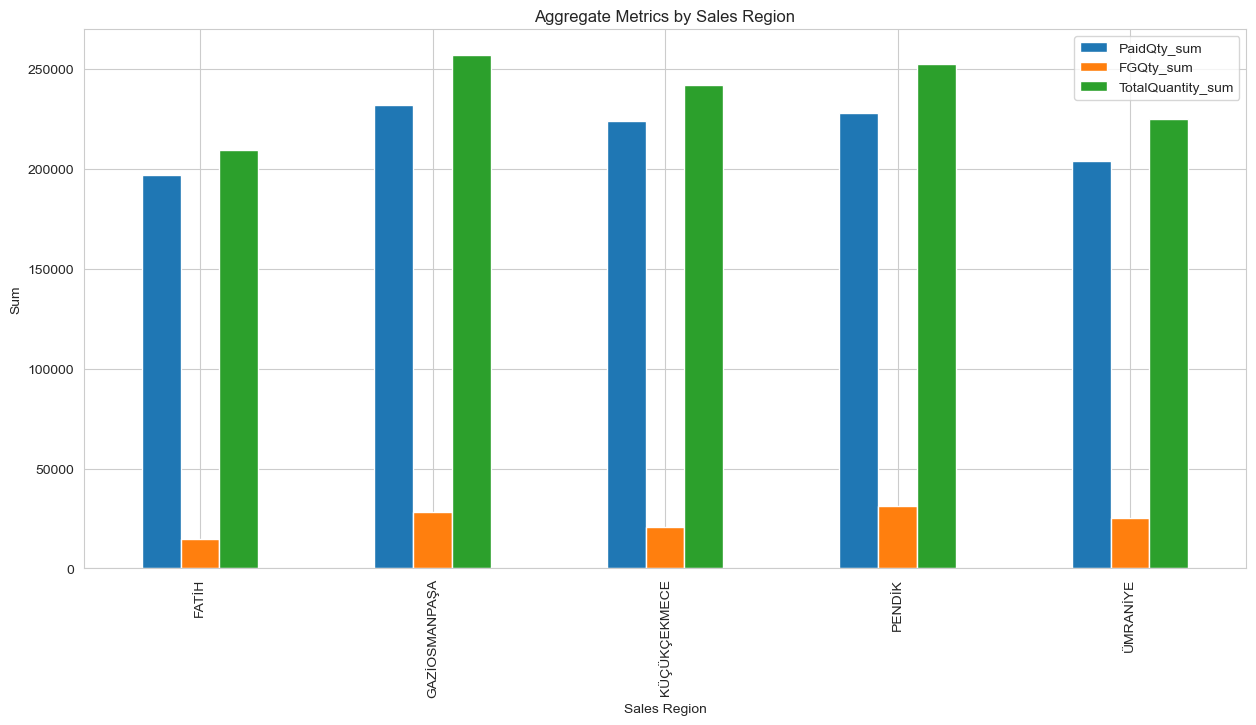

In [29]:
# Grouping by Sales Region and calculating aggregate metrics
district_agg = data.groupby('District').agg({
    'PaidQty': ['sum', 'mean', 'std'],
    'FGQty': ['sum', 'mean', 'std'],
    'TotalQuantity': ['sum', 'mean', 'std']
}).reset_index()

district_agg.columns = ['District', 'PaidQty_sum', 'PaidQty_mean', 'PaidQty_std', 
                            'FGQty_sum', 'FGQty_mean', 'FGQty_std',
                            'TotalQuantity_sum', 'TotalQuantity_mean', 'TotalQuantity_std']

print(district_agg)

# Visualizing aggregate metrics
district_agg.plot(x='District', y=['PaidQty_sum', 'FGQty_sum', 'TotalQuantity_sum'], kind='bar', figsize=(15, 7))
plt.title('Aggregate Metrics by Sales Region')
plt.xlabel('Sales Region')
plt.ylabel('Sum')
plt.show()


In [30]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

df_cleaned = data.copy()
df_cleaned = df_cleaned[['MainDistID', 'DistID', 'HcoID', 'HcoType', 'District', 'Status', 'IsReturn', 'IsMrsOrder', 'TotalQuantity', 'SkuID', 'Date']]

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181681 entries, 1264 to 4191737
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   MainDistID     181681 non-null  object        
 1   DistID         181681 non-null  object        
 2   HcoID          181681 non-null  object        
 3   HcoType        181681 non-null  category      
 4   District       181681 non-null  category      
 5   Status         181681 non-null  category      
 6   IsReturn       181681 non-null  bool          
 7   IsMrsOrder     181681 non-null  bool          
 8   TotalQuantity  181681 non-null  int64         
 9   SkuID          181681 non-null  object        
 10  Date           181681 non-null  datetime64[ns]
dtypes: bool(2), category(3), datetime64[ns](1), int64(1), object(4)
memory usage: 10.6+ MB


In [31]:
# Label Encoding for binary categorical variables
label_encoder = LabelEncoder()
df_cleaned['IsReturn'] = label_encoder.fit_transform(df_cleaned['IsReturn'])
df_cleaned['IsMrsOrder'] = label_encoder.fit_transform(df_cleaned['IsMrsOrder'])

# One-Hot Encoding for other categorical variables
df_encoded = pd.get_dummies(df_cleaned, columns=['MainDistID', 'DistID', 'HcoID', 'HcoType', 'District', 'Status'])

print('Data after encoding:')
print(df_encoded.head())

Data after encoding:
      IsReturn  IsMrsOrder  TotalQuantity SkuID       Date  \
1264         0           0              1   319 2019-01-03   
1267         0           0              1   319 2019-01-07   
1268         0           0              1   319 2019-01-07   
1270         0           0              1   319 2019-01-08   
1273         0           0              4   319 2019-01-14   

      MainDistID_2879231  MainDistID_2879236  MainDistID_2879239  \
1264               False               False               False   
1267               False               False               False   
1268               False               False               False   
1270               False               False               False   
1273               False               False               False   

      MainDistID_2879243  MainDistID_2879249  ...  HcoType_H  HcoType_P  \
1264               False               False  ...      False       True   
1267               False               False  .

# Sales Analysis

In [48]:
monthly_data = data.copy()

monthly_data['Year'] = monthly_data['Date'].dt.year
monthly_data['Month'] = monthly_data['Date'].dt.month

monthly_data = monthly_data.groupby(['Year', 'Month', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
monthly_data

Year  Month SkuID  TotalQuantity
0    2019      1  1018            897
1    2019      1  1050           4375
2    2019      1   319           3450
3    2019      1   509           2909
4    2019      1   568          11828
..    ...    ...   ...            ...
247  2021     12   319           5877
248  2021     12   509           2547
249  2021     12   568          10953
250  2021     12   578           6199
251  2021     12   615           2636

[252 rows x 4 columns]

SKU 568


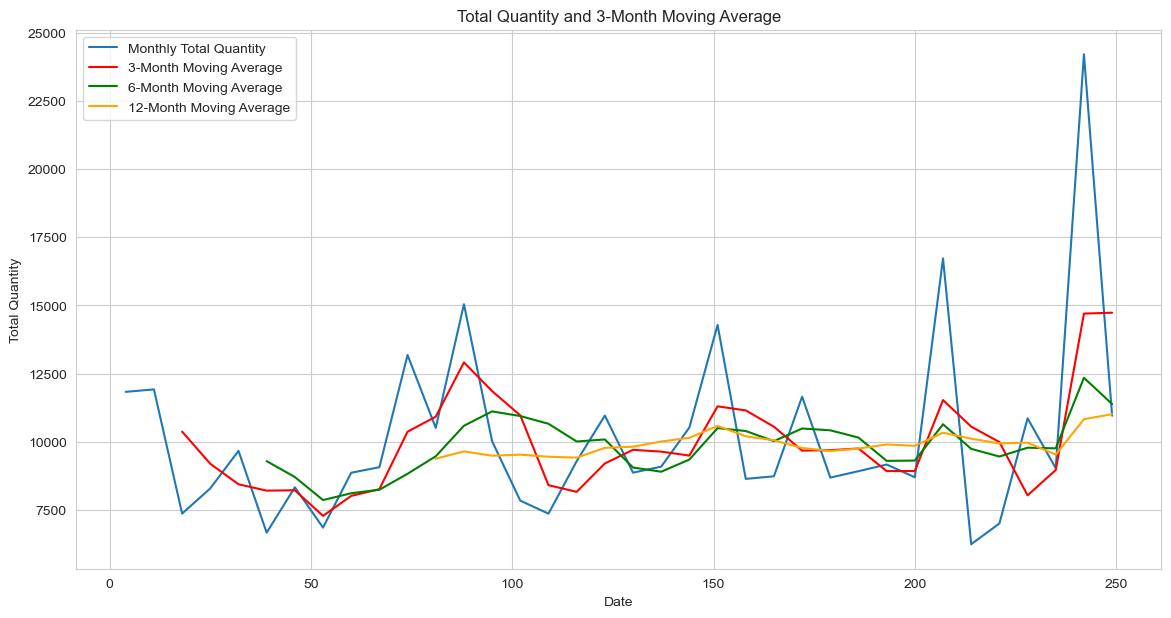

SKU 578


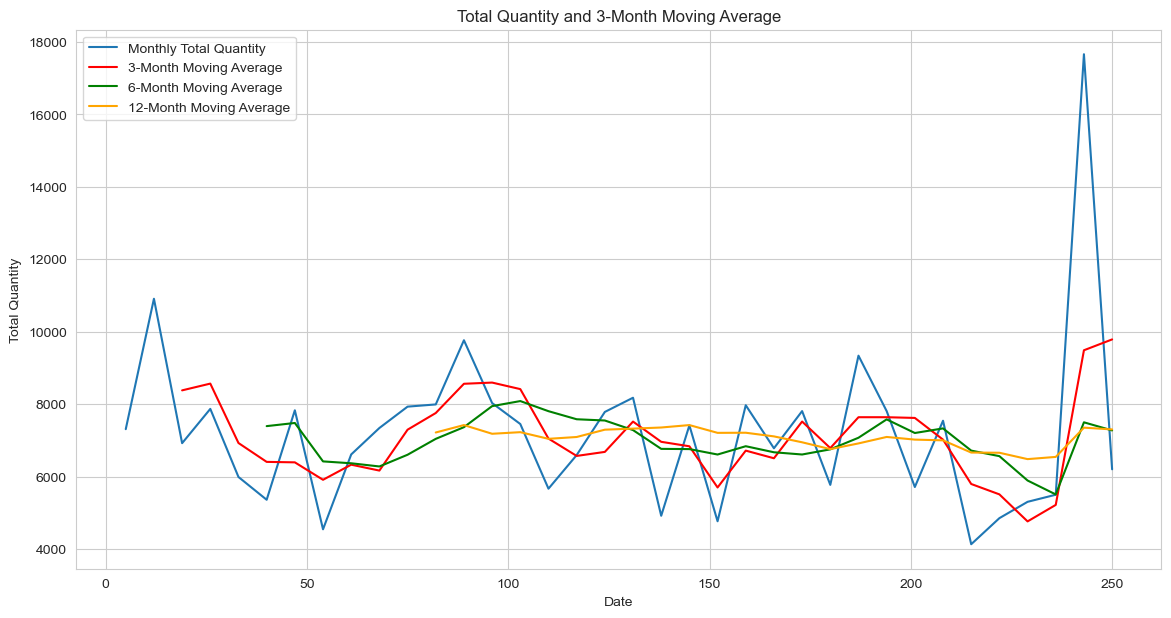

SKU 1050


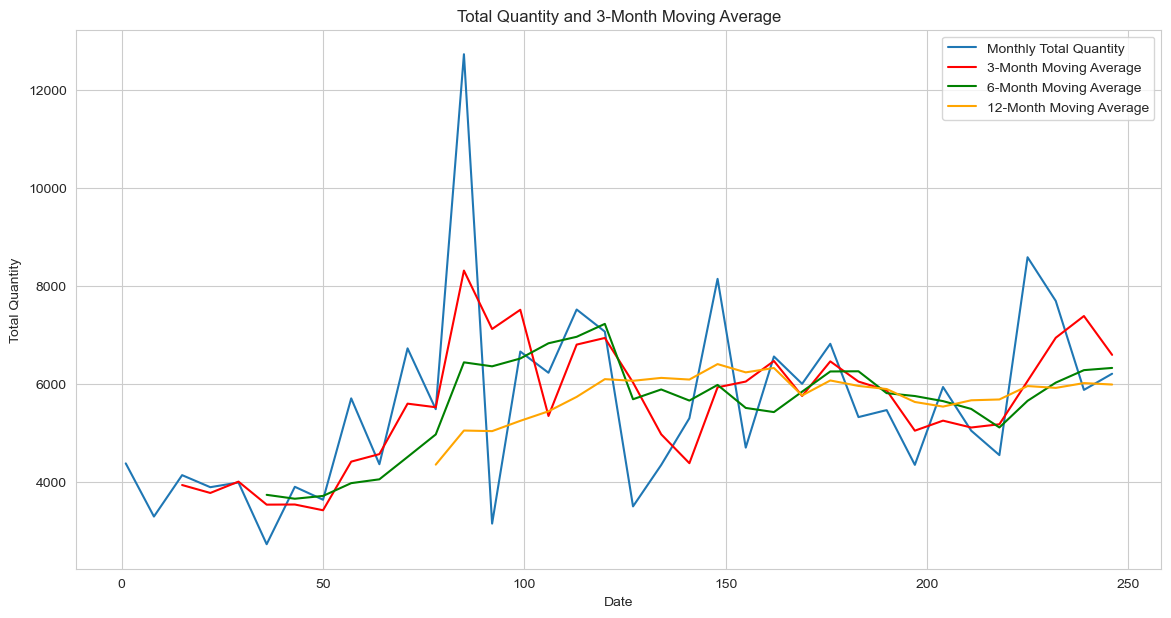

SKU 319


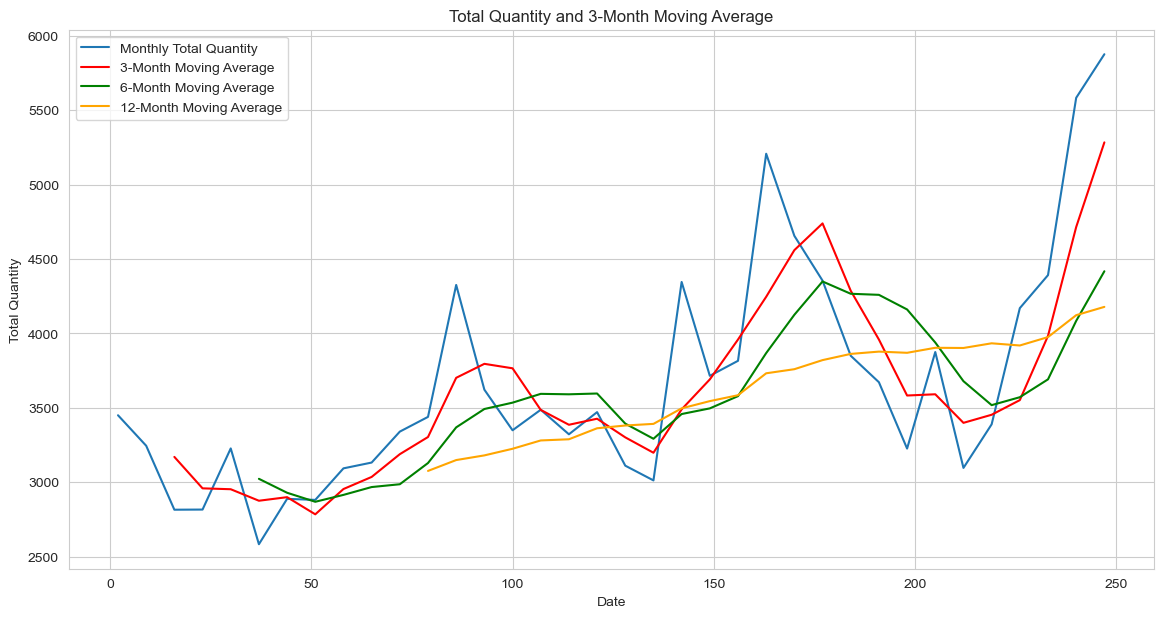

SKU 509


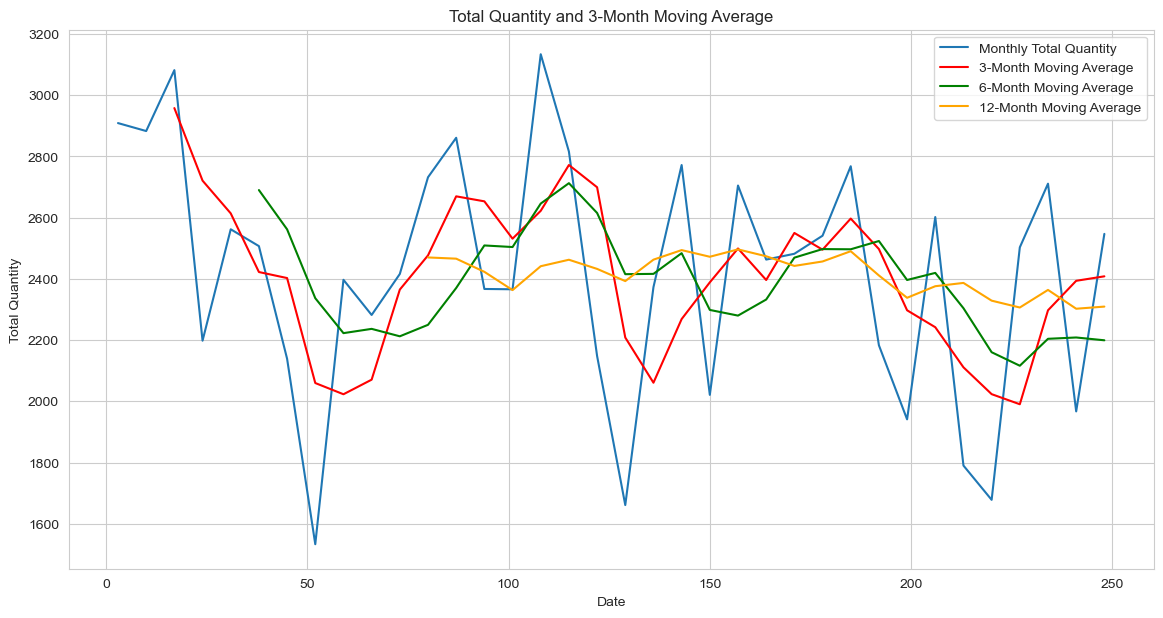

SKU 615


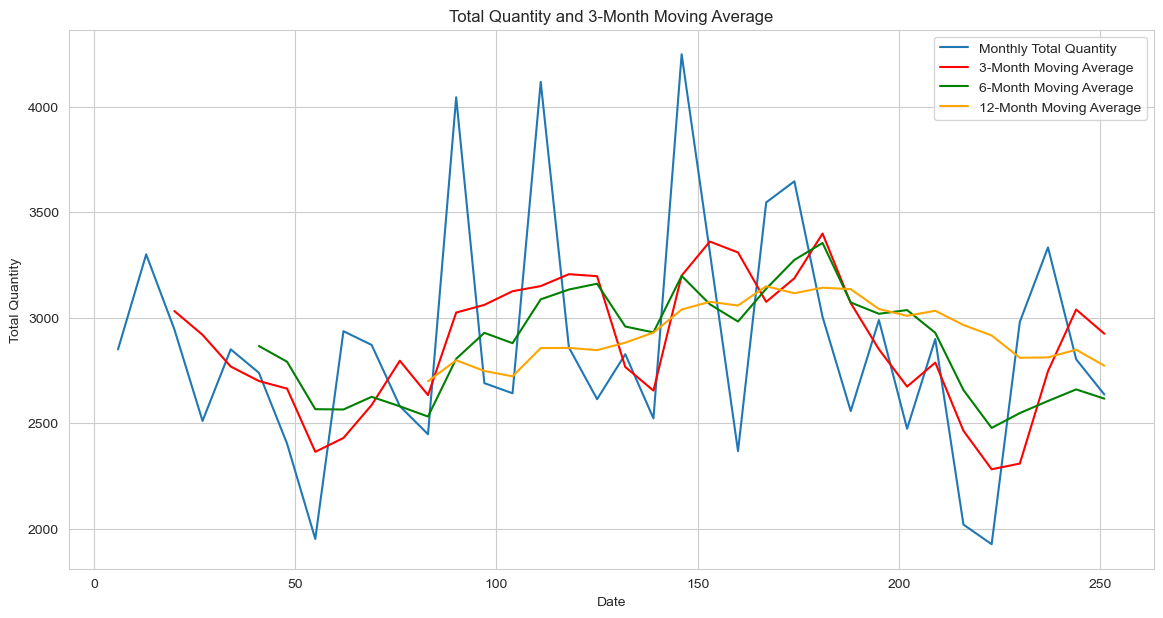

SKU 1018


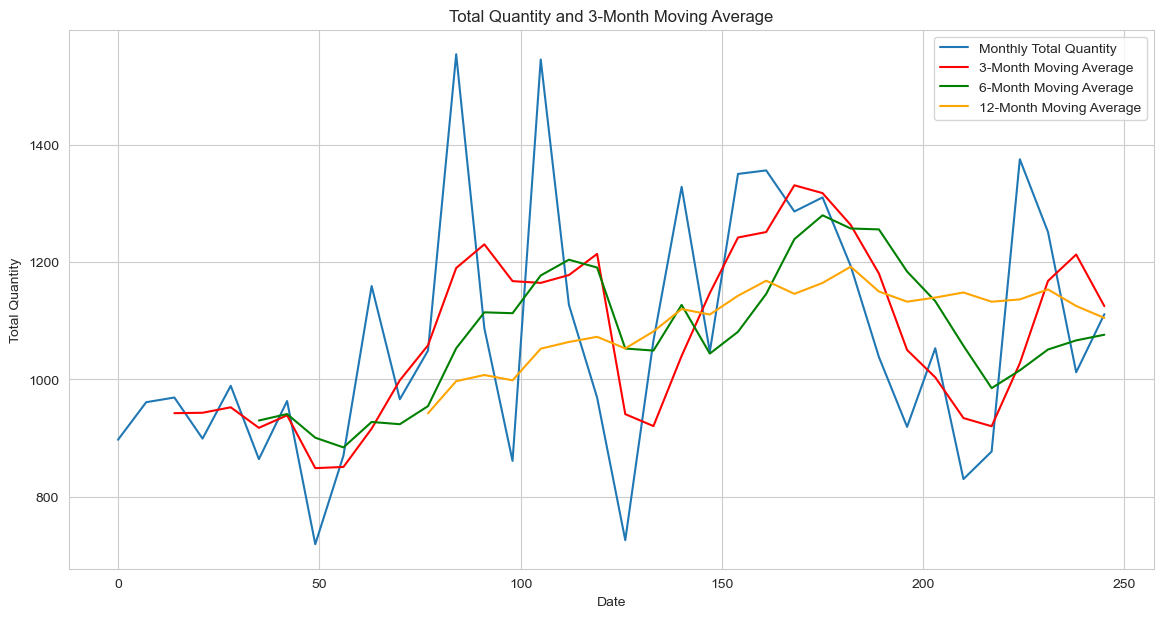

In [49]:
# Implementing Moving Average for each SKU to see the trend and seasonality
for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    
    # Calculate the moving average
    sku_data['Moving_Average_3'] = sku_data['TotalQuantity'].rolling(window=3).mean()
    sku_data['Moving_Average_6'] = sku_data['TotalQuantity'].rolling(window=6).mean()
    sku_data['Moving_Average_12'] = sku_data['TotalQuantity'].rolling(window=12).mean()
    
    plt.figure(figsize=(14, 7))
    plt.plot(sku_data['TotalQuantity'], label='Monthly Total Quantity')
    
    plt.plot(sku_data['Moving_Average_3'], label='3-Month Moving Average', color='red')
    plt.plot(sku_data['Moving_Average_6'], label='6-Month Moving Average', color='green')
    plt.plot(sku_data['Moving_Average_12'], label='12-Month Moving Average', color='orange')

    plt.title('Total Quantity and 3-Month Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Total Quantity')
    plt.legend()
    plt.show()

# Quarterly Sales Analysis

Calculate the total sales of the choosen SKU's for quarterly. It should be 12 rows in total for every SKU.

In [50]:
quarterly_data = df_encoded.copy()
quarterly_data['Year'] = quarterly_data['Date'].dt.year
quarterly_data['Quarter'] = quarterly_data['Date'].dt.quarter

quarterly_data = quarterly_data.groupby(['Year', 'Quarter', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
quarterly_data

Year  Quarter SkuID  TotalQuantity
0   2019        1  1018           2827
1   2019        1  1050          11800
2   2019        1   319           9510
3   2019        1   509           8874
4   2019        1   568          31108
..   ...      ...   ...            ...
79  2021        4   319          15853
80  2021        4   509           7225
81  2021        4   568          44191
82  2021        4   578          29360
83  2021        4   615           8772

[84 rows x 4 columns]

In [51]:
sku_319 = quarterly_data[quarterly_data['SkuID'] == "319"]
sku_319

Year  Quarter SkuID  TotalQuantity
2   2019        1   319           9510
9   2019        2   319           8626
16  2019        3   319           8862
23  2019        4   319           9911
30  2020        1   319          11297
37  2020        2   319          10280
44  2020        3   319          10469
51  2020        4   319          12739
58  2021        1   319          12861
65  2021        2   319          10773
72  2021        3   319          10655
79  2021        4   319          15853

## Total Quantity of SKU's for each quarter

In [52]:
# Plot SKU sales for each quarter    
def plot_sku(sku_id):
    sku = quarterly_data[quarterly_data['SkuID'] == sku_id]
    plt.figure(figsize=(12, 6))
    plt.plot(sku['Year'].astype(str) + '-' + sku['Quarter'].astype(str), sku['TotalQuantity'])
    plt.title(f'SKU {sku_id} Total Quantity by Quarter')
    plt.xlabel('Quarter')
    plt.ylabel('Total Quantity')
    plt.xticks(rotation=45)
    plt.show()

SKU 568
Year  Quarter
2019  1          31108
      2          24614
      3          24037
      4          32749
2020  1          32894
      2          27601
      3          28471
      4          31648
2021  1          29252
      2          34578
      3          24096
      4          44191
Name: TotalQuantity, dtype: int64


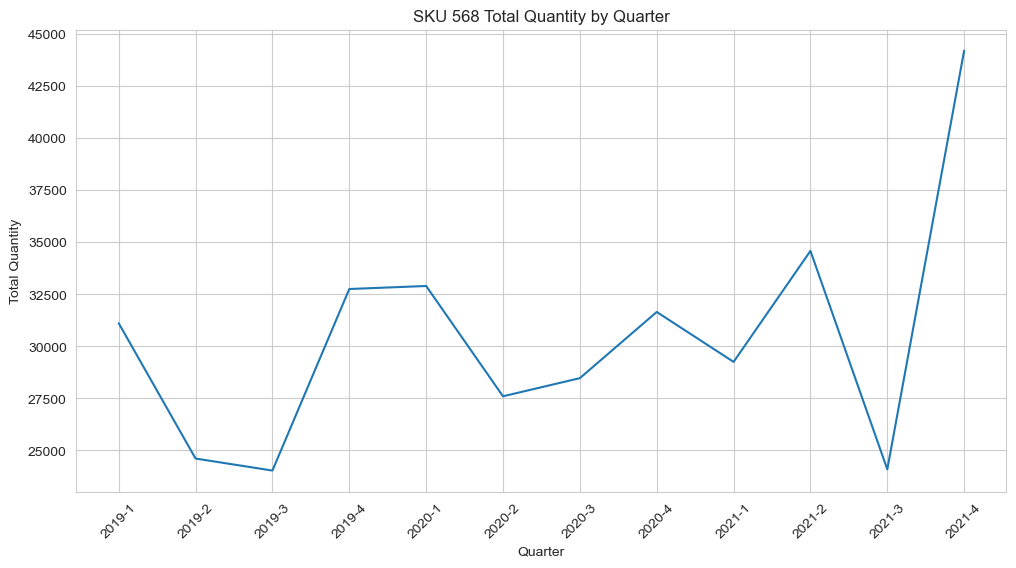

SKU 578
Year  Quarter
2019  1          25139
      2          19213
      3          18981
      4          23261
2020  1          25243
      2          20040
      3          20505
      4          19513
2021  1          22914
      2          21058
      3          14281
      4          29360
Name: TotalQuantity, dtype: int64


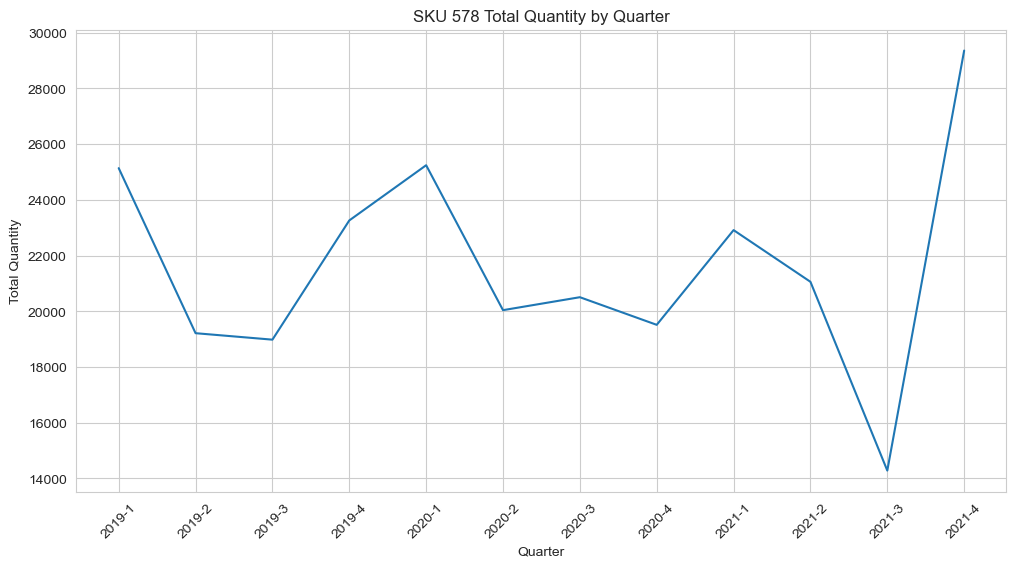

SKU 1050
Year  Quarter
2019  1          11800
      2          10599
      3          13232
      4          16563
2020  1          22531
      2          20806
      3          13137
      4          19396
2021  1          18135
      2          15742
      3          18170
      4          19771
Name: TotalQuantity, dtype: int64


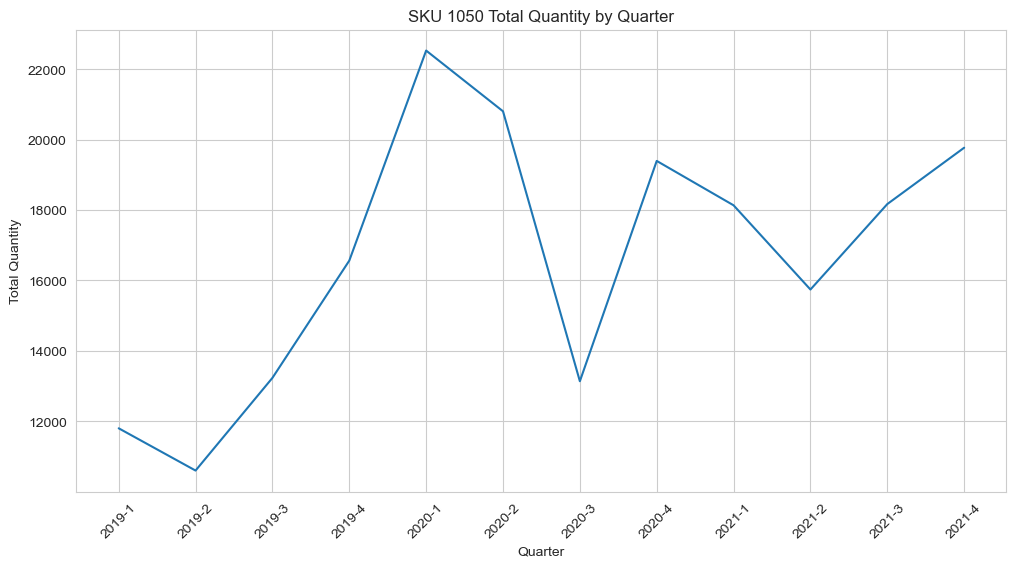

SKU 319
Year  Quarter
2019  1           9510
      2           8626
      3           8862
      4           9911
2020  1          11297
      2          10280
      3          10469
      4          12739
2021  1          12861
      2          10773
      3          10655
      4          15853
Name: TotalQuantity, dtype: int64


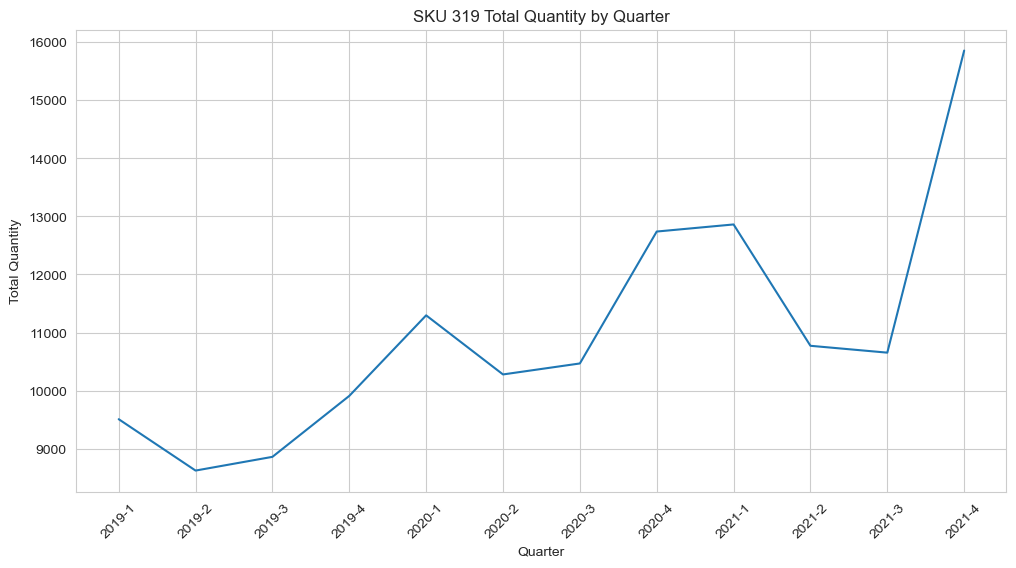

SKU 509
Year  Quarter
2019  1          8874
      2          7267
      3          6069
      4          7430
2020  1          7594
      2          8098
      3          6806
      4          7189
2021  1          7791
      2          6726
      3          5971
      4          7225
Name: TotalQuantity, dtype: int64


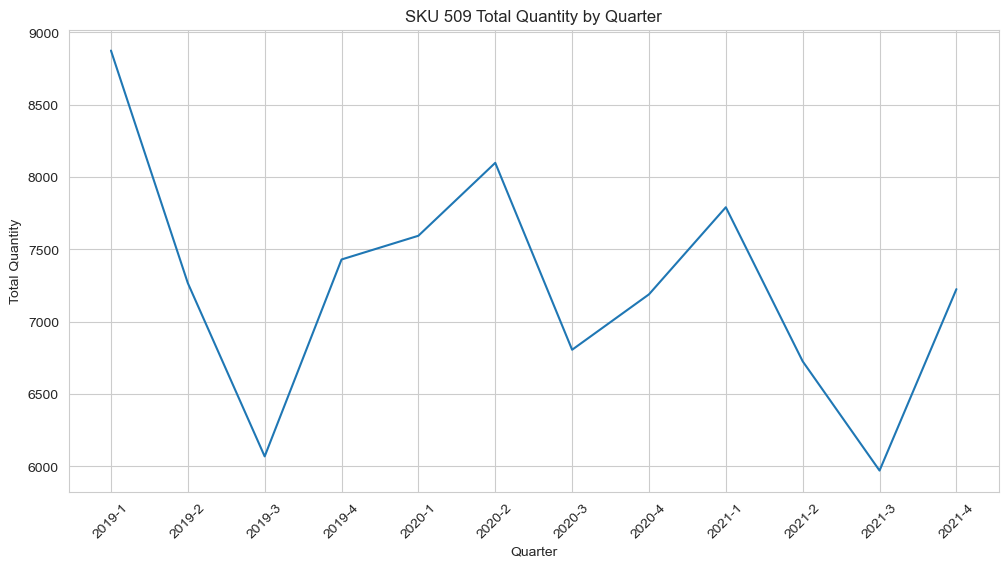

SKU 615
Year  Quarter
2019  1          9095
      2          8100
      3          7291
      4          7900
2020  1          9376
      2          9590
      3          9598
      4          9225
2021  1          9208
      2          8362
      3          6927
      4          8772
Name: TotalQuantity, dtype: int64


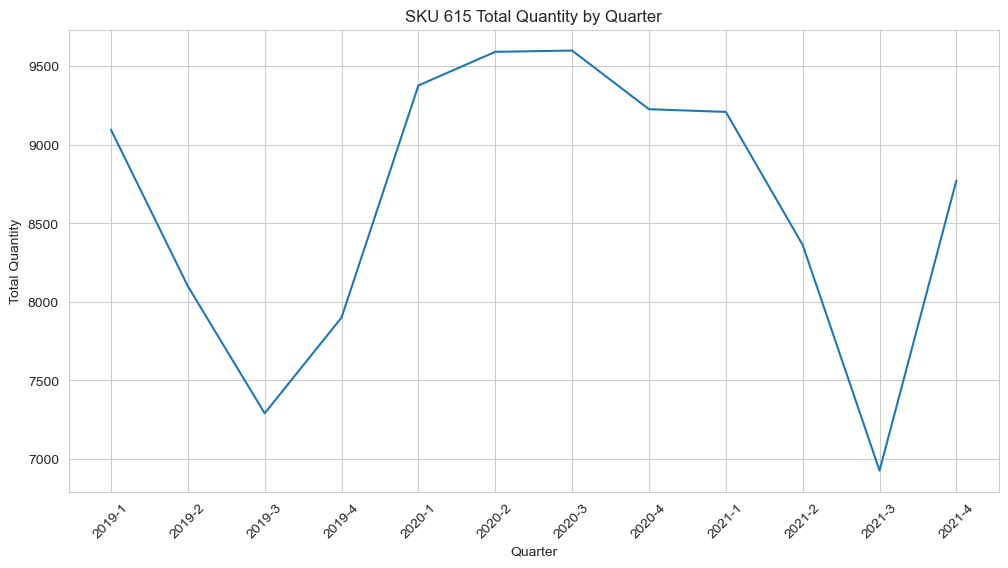

SKU 1018
Year  Quarter
2019  1          2827
      2          2752
      3          2552
      4          3174
2020  1          3502
      2          3641
      3          3120
      4          3753
2021  1          3789
      2          3010
      3          3082
      4          3374
Name: TotalQuantity, dtype: int64


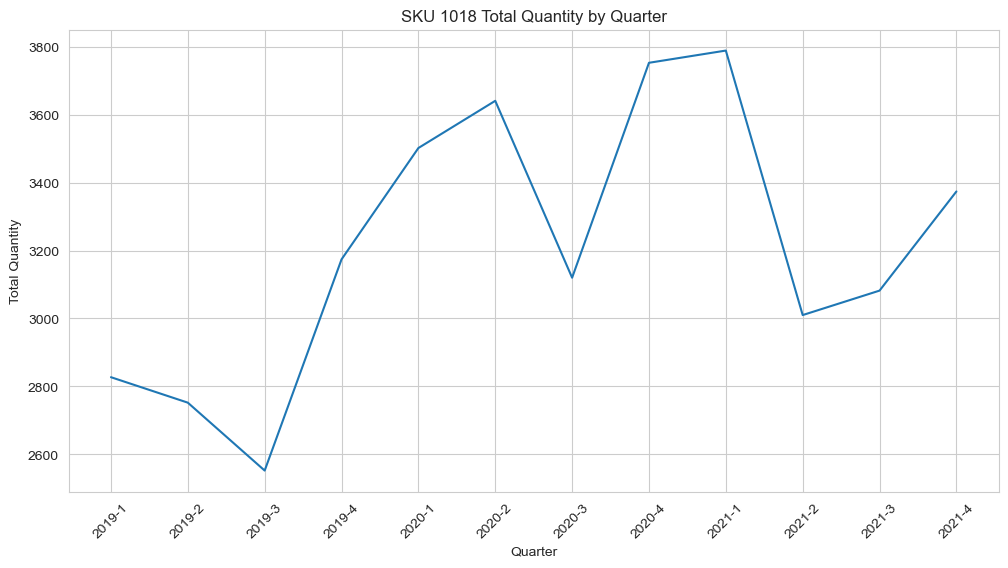

In [53]:
for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = quarterly_data[quarterly_data['SkuID'] == sku_id]
    sku_data.set_index(['Year', 'Quarter'], inplace=True)
    print(sku_data['TotalQuantity'])
    plot_sku(sku_id)

Control these:
- Trend 
- Seasonality
- Cyclical
- Random

## Forecasting

### Exponential Smoothing

In [93]:
def calculate_metrics(actual, forecast):
    mape = (abs(forecast - actual) / actual).mean()
    mse = ((forecast - actual) ** 2).mean()
    rmse = mse ** 0.5
    bias = (forecast - actual).mean()
    mad = (abs(forecast - actual)).mean()
    return mape, mse, rmse, bias, mad

In [94]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

exponential_smoothing_forecast = []

def forecast_sku_ExponentialSmoothing(sku_id):
    sku_data = quarterly_data[quarterly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-4]
    test = sku_data['TotalQuantity'][-4:]
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=4).fit()
    forecast = model.forecast(4)
    forecast = forecast.astype(int)
    forecast_table = pd.DataFrame({'Year': [2020, 2020, 2020, 2020], 'Quarter': [1, 2, 3, 4], 'Forecasted': forecast, 'Actual': 
                                test.values, 'Error': test.values - forecast})
    
    forecast_table.set_index(['Year', 'Quarter'], inplace=True)
    
    mape, mse, rmse, bias, mad = calculate_metrics(test.values, forecast)
    exponential_smoothing_forecast.append({'sku_id': sku_id, 'mape': round(mape, 3), 'mse': round(mse, 3), 'rmse': round(rmse, 3), 'bias': round(bias, 3), 'mad': round(mad, 3)})

    
    print(f'SKU {sku_id} Exponential Smoothing Forecast'f'\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAD: {mad}')
    print('===============\n')

In [95]:
for sku_id in all_sku_ids:
    forecast_sku_ExponentialSmoothing(sku_id)

SKU 568 Exponential Smoothing Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1            152094  139976 -12118
     2            129495  165927  36432
     3            128604  114512 -14092
     4            159160  225966  66806

MAPE: 0.1812115014565409
MSE: 1533940662.0
RMSE: 39165.55453456519
MAD: 32362.0

SKU 578 Exponential Smoothing Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             98056   91852  -6204
     2             85657   81332  -4325
     3             74441   60905 -13536
     4             88908  109939  21031

MAPE: 0.13356632389693576
MSE: 170680374.5
RMSE: 13064.469928014683
MAD: 11274.0

SKU 1050 Exponential Smoothing Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             64242   78269  14027
     2             57915   69268  11353
     3             71369   79958   8589
     4             87021   90674  

In [96]:
exponential_smoothing_forecast = pd.DataFrame(exponential_smoothing_forecast)
exponential_smoothing_forecast.set_index('sku_id', inplace=True)
exponential_smoothing_forecast

mape           mse       rmse      bias       mad
sku_id                                                    
568     0.181  1.533941e+09  39165.555 -19257.00  32362.00
578     0.134  1.706804e+08  13064.470    758.50  11274.00
1050    0.123  1.031907e+08  10158.281  -9405.50   9405.50
319     0.079  8.609675e+07   9278.834  -5668.25   5668.25
509     0.060  7.612652e+06   2759.103   1560.00   2155.00
615     0.124  2.088601e+07   4570.121   2976.75   3861.75
1018    0.076  2.577900e+06   1605.584   -659.00   1373.50

### Moving Average

Moving average is a simple forecasting method that calculates the average of the previous n observations. It is used to smooth out short-term fluctuations and highlight longer-term trends or cycles.

#### How to determine the period of the moving average?

First, we need to determine the period of the moving average. We can use the Mean Absolute Percentage Error (MAPE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and bias to evaluate the performance of the moving average method. 

The period with the lowest MAPE, MSE, RMSE, and bias values will be the best period for the moving average method.

<hr />

#### RMSE (Root Mean Squared Error)
RMSE gives you the average error of the model in predicting the outcome for each observation. Lower RMSE values indicate better fit between predicted and actual values. It's particularly useful because it provides a measure of how much the model's predictions deviate from the actual values on average.





In [97]:
import numpy as np

def moving_average_forecast_list(data, window_size):
    forecast = []
    for i in range(len(data) - window_size + 1):
        forecast.append(np.mean(data[i:i+window_size]))
    return forecast

def find_best_window_size(data, min_window=2, max_window=None):
    if max_window is None:
        max_window = len(data) // 2

    best_score = float('inf')
    best_window = None
    
    results = []

    for window_size in range(min_window, max_window + 1):
        forecast = moving_average_forecast_list(data, window_size)
        # Align forecast with actual data
        forecast = [None] * (window_size - 1) + forecast
        mape, mse, rmse, bias, mad = calculate_metrics(data[window_size - 1:], forecast[window_size - 1:])
        results.append({'window': window_size, 'mape': mape, 'mse': mse, 'rmse': rmse, 'bias': bias, 'mad': mad})
        score = mape
        if score < best_score:
            best_score = score
            best_window = window_size
            
    results = pd.DataFrame(results)
    results.set_index('window', inplace=True)
    print(results)

    return best_window

In [98]:
sku_data = quarterly_data[quarterly_data['SkuID'] == '568']

best_window = find_best_window_size(sku_data['TotalQuantity'], min_window=2, max_window=6)
best_window

            mape           mse          rmse         bias           mad
window                                                                 
2       0.090404  4.235229e+08  20579.671058 -3640.318182  14280.500000
3       0.110709  5.279329e+08  22976.791205 -5783.033333  17494.500000
4       0.117427  6.817981e+08  26111.264539 -8899.166667  19147.833333
5       0.109405  7.258868e+08  26942.285756 -8477.375000  18248.775000
6       0.117981  8.698996e+08  29494.060682 -8833.023810  19969.690476


2

In [99]:
moving_average_forecast = []

def forecast_sku_MovingAverage(sku_id):
    # make 2 period moving average forecast
    sku_data = quarterly_data[quarterly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-4]
    test = sku_data['TotalQuantity'][-4:]
    forecast = train.rolling(window=best_window).mean().values[-1]
    forecast = forecast.astype(int)
    
    forecast_table = pd.DataFrame({'Year': [2020, 2020, 2020, 2020], 'Quarter': [1, 2, 3, 4], 'Forecasted': forecast, 'Actual':
                                test.values, 'Error': test.values - forecast})
    forecast_table.set_index(['Year', 'Quarter'], inplace=True)
    
    mape, mse, rmse, bias, mad = calculate_metrics(test.values, forecast)
    
    moving_average_forecast.append({'sku_id': sku_id, 'mape': round(mape, 3), 'mse': round(mse, 3), 'rmse': round(rmse, 3), 'bias': round(bias, 3), 'mad': round(mad, 3)})
    
    print(f'SKU {sku_id} Moving Average Forecast'f'\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print('===============\n')

In [100]:
for sku_id in all_sku_ids:
    forecast_sku_MovingAverage(sku_id)

SKU 568 Moving Average Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1            146227  139976  -6251
     2            146227  165927  19700
     3            146227  114512 -31715
     4            146227  225966  79739

MAPE: 0.19830574022096692
MSE: 1947828586.75
RMSE: 44134.211069758574

SKU 578 Moving Average Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             78970   91852  12882
     2             78970   81332   2362
     3             78970   60905 -18065
     4             78970  109939  30969

MAPE: 0.18689771571995806
MSE: 364237038.5
RMSE: 19084.99511396322

SKU 1050 Moving Average Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             70193   78269   8076
     2             70193   69268   -925
     3             70193   79958   9765
     4             70193   90674  20481

MAPE: 0.11613456824667501
MSE: 1452259

In [101]:
moving_average_forecast = pd.DataFrame(moving_average_forecast)
moving_average_forecast.set_index('sku_id', inplace=True)
moving_average_forecast

mape           mse       rmse      bias       mad
sku_id                                                    
568     0.198  1.947829e+09  44134.211 -15368.25  34351.25
578     0.187  3.642370e+08  19084.995  -7037.00  16069.50
1050    0.116  1.452260e+08  12050.975  -9349.25   9811.75
319     0.121  1.288461e+08  11351.038  -5909.50   8278.00
509     0.086  1.090382e+07   3302.094   -971.50   3032.00
615     0.129  2.209720e+07   4700.766   1482.25   4051.75
1018    0.118  7.078773e+06   2660.596  -1502.25   2174.75

### Naive Forecast

In [102]:
naive_forecast = []

def forecast_sku_Naive(sku_id):
    sku_data = quarterly_data[quarterly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-4]
    test = sku_data['TotalQuantity'][-4:]
    forecast = train.iloc[-1]
    forecast = forecast.astype(int)
    forecast_table = pd.DataFrame({'Year': [2020, 2020, 2020, 2020], 'Quarter': [1, 2, 3, 4], 'Forecasted': forecast, 'Actual': 
                                test.values, 'Error': test.values - forecast})
    
    forecast_table.set_index(['Year', 'Quarter'], inplace=True)
    mape, mse, rmse, bias, mad = calculate_metrics(test.values, forecast)
    naive_forecast.append({'sku_id': sku_id, 'mape': round(mape, 3), 'mse': round(mse, 3), 'rmse': round(rmse, 3), 'bias': round(bias, 3), 'mad': round(mad, 3)})
    
    
    print(f'SKU {sku_id} Naive Forecast'f'\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print('===============\n')
    

In [103]:
for sku_id in all_sku_ids:
    forecast_sku_Naive(sku_id)

SKU 568 Naive Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1            154361  139976 -14385
     2            154361  165927  11566
     3            154361  114512 -39849
     4            154361  225966  71605

MAPE: 0.20933666399672202
MSE: 1763979851.75
RMSE: 41999.760139196034

SKU 578 Naive Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             78047   91852  13805
     2             78047   81332   3285
     3             78047   60905 -17142
     4             78047  109939  31892

MAPE: 0.19055724982646027
MSE: 378079269.5
RMSE: 19444.26057992435

SKU 1050 Naive Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             82377   78269  -4108
     2             82377   69268 -13109
     3             82377   79958  -2419
     4             82377   90674   8297

MAPE: 0.09087327934514079
MSE: 65853328.75
RMSE: 8115.00639248053

In [104]:
naive_forecast = pd.DataFrame(naive_forecast)
naive_forecast.set_index('sku_id', inplace=True)
naive_forecast

mape           mse       rmse     bias       mad
sku_id                                                   
568     0.209  1.763980e+09  41999.760 -7234.25  34351.25
578     0.191  3.780793e+08  19444.261 -7960.00  16531.00
1050    0.091  6.585333e+07   8115.006  2834.75   6983.25
319     0.130  9.668778e+07   9832.994 -1662.50   8278.00
509     0.089  1.003646e+07   3168.038   276.50   3032.00
615     0.128  2.090665e+07   4572.379  1003.25   4051.75
1018    0.128  4.852034e+06   2202.733  -173.25   2174.75

## Seasonal Forecasting Methods

There are seasonal patterns in the quarterly_data. So, we can use forecasting methods that can capture the seasonality.
- Triple Exponential Smoothing
- ARIMA
- SARIMA

### Triple Exponential Smoothing

In [105]:
triple_exponential_smoothing_forecast = []

def forecast_sku_TripleExponentialSmoothing(sku_id):
    sku_data = quarterly_data[quarterly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-4]
    test = sku_data['TotalQuantity'][-4:]
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=4, trend='add').fit()
    forecast = model.forecast(4)
    forecast = forecast.astype(int)
    forecast_table = pd.DataFrame({'Year': [2020, 2020, 2020, 2020], 'Quarter': [1, 2, 3, 4], 'Forecasted': forecast, 'Actual': 
                                test.values, 'Error': test.values - forecast})

    forecast_table.set_index(['Year', 'Quarter'], inplace=True)
    
    # calculate parameters for the forecast exponential smoothing model, alpha, beta, gamma
    
    
    
    
    mape, mse, rmse, bias, mad = calculate_metrics(test.values, forecast)
    triple_exponential_smoothing_forecast.append({'sku_id': sku_id, 'mape': round(mape, 3), 'mse': round(mse, 3), 'rmse': round(rmse, 3), 'bias': round(bias, 3), 'mad': round(mad, 3)})
    
    print(f'SKU {sku_id} Triple Exponential Smoothing Forecast'f'\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print('===============\n')

    

In [106]:
for sku_id in all_sku_ids:
    forecast_sku_TripleExponentialSmoothing(sku_id)

SKU 568 Triple Exponential Smoothing Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1            161709  139976 -21733
     2            139646  165927  26281
     3            145978  114512 -31466
     4            172791  225966  53175

MAPE: 0.20593942569113707
MSE: 1245176007.75
RMSE: 35287.05155931847

SKU 578 Triple Exponential Smoothing Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             94644   91852  -2792
     2             81172   81332    160
     3             68392   60905  -7487
     4             87178  109939  22761

MAPE: 0.09058152837787799
MSE: 145484788.5
RMSE: 12061.70752837259

SKU 1050 Triple Exponential Smoothing Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1            121266   78269 -42997
     2            109904   69268 -40636
     3             80652   79958   -694
     4            121213   90674 -3053

In [107]:
triple_exponential_smoothing_forecast = pd.DataFrame(triple_exponential_smoothing_forecast)
triple_exponential_smoothing_forecast.set_index('sku_id', inplace=True)
triple_exponential_smoothing_forecast

mape           mse       rmse      bias       mad
sku_id                                                    
568     0.206  1.245176e+09  35287.052  -6564.25  33163.75
578     0.091  1.454848e+08  12061.708  -3160.50   8300.00
1050    0.370  1.108285e+09  33290.910  28716.50  28716.50
319     0.079  4.621449e+07   6798.124  -2875.50   5248.00
509     0.075  1.094344e+07   3308.086   2549.00   2592.50
615     0.164  3.077551e+07   5547.568   5286.00   5286.00
1018    0.085  2.727552e+06   1651.530    916.75   1323.25

### ARIMA

In [108]:
from statsmodels.tsa.arima.model import ARIMA

arima_forecast = []

def forecast_sku_ARIMA(sku_id):
    sku_data = quarterly_data[quarterly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-4]
    test = sku_data['TotalQuantity'][-4:]
    model = ARIMA(train, order=(1, 1, 1)).fit()
    forecast = model.forecast(steps=4)
    forecast = forecast.astype(int)
    forecast_table = pd.DataFrame({'Year': [2020, 2020, 2020, 2020], 'Quarter': [1, 2, 3, 4], 'Forecasted': forecast, 'Actual': 
                                test.values, 'Error': test.values - forecast})
    forecast_table.set_index(['Year', 'Quarter'], inplace=True)
    
    mape, mse, rmse, bias, mad = calculate_metrics(test.values, forecast)
    arima_forecast.append({'sku_id': sku_id, 'mape': round(mape, 3), 'mse': round(mse, 3), 'rmse': round(rmse, 3), 'bias': round(bias, 3), 'mad': round(mad, 3)})
    
    print(f'SKU {sku_id} ARIMA Forecast'f'\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print('===============\n')
    

In [109]:
for sku_id in all_sku_ids:
    forecast_sku_ARIMA(sku_id)

SKU 568 ARIMA Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1            151601  139976 -11625
     2            151457  165927  14470
     3            151450  114512 -36938
     4            151449  225966  74517

MAPE: 0.20564916010672687
MSE: 1815430164.5
RMSE: 42607.86505447087

SKU 578 ARIMA Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             79021   91852  12831
     2             79245   81332   2087
     3             79296   60905 -18391
     4             79308  109939  30631

MAPE: 0.18648314624826967
MSE: 361369293.0
RMSE: 19009.715752740754

SKU 1050 ARIMA Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             80114   78269  -1845
     2             80143   69268 -10875
     3             80142   79958   -184
     4             80142   90674  10532

MAPE: 0.07475625801232283
MSE: 58156632.5
RMSE: 7626.049599891152


In [110]:
arima_forecast = pd.DataFrame(arima_forecast)
arima_forecast.set_index('sku_id', inplace=True)
arima_forecast

mape           mse       rmse      bias       mad
sku_id                                                    
568     0.206  1.815430e+09  42607.865 -10106.00  34387.50
578     0.186  3.613693e+08  19009.716  -6789.50  15985.00
1050    0.075  5.815663e+07   7626.050    593.00   5859.00
319     0.128  1.000076e+08  10000.378  -2469.75   8269.75
509     0.088  1.961854e+07   4429.282  -3246.00   3281.50
615     0.121  1.885622e+07   4342.375   -714.75   4034.75
1018    0.125  5.015902e+06   2239.621   -480.75   2166.75

### SARIMA

In [111]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_forecast = []

def forecast_sku_SARIMA(sku_id):
    sku_data = quarterly_data[quarterly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-4]
    test = sku_data['TotalQuantity'][-4:]
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4)).fit()
    forecast = model.forecast(steps=4)
    forecast = forecast.astype(int)
    forecast_table = pd.DataFrame({'Year': [2020, 2020, 2020, 2020], 'Quarter': [1, 2, 3, 4], 'Forecasted': forecast, 'Actual': 
                                test.values, 'Error': test.values - forecast})
    forecast_table.set_index(['Year', 'Quarter'], inplace=True)
    
    mape, mse, rmse, bias, mad = calculate_metrics(test.values, forecast)
    
    # store the SARIMA forecast values in the sarima_forecast table to compare with other forecasting methods
    sarima_forecast.append({'sku_id': sku_id, 'mape': round(mape, 3), 'mse': round(mse, 3), 'rmse': round(rmse, 3), 'bias': round(bias, 3), 'mad': round(mad, 3)})
    
    print('===============\n')
    print(f'SKU {sku_id} ARIMA Forecast'f'\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print('===============\n')


In [112]:
for sku_id in all_sku_ids:
    forecast_sku_SARIMA(sku_id)
    

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10786D+00    |proj g|=  8.11347D-01

At iterate    5    f=  3.88460D+00    |proj g|=  6.49146D-02


 This problem is unconstrained.



At iterate   10    f=  3.84702D+00    |proj g|=  7.28310D-02

At iterate   15    f=  3.84303D+00    |proj g|=  1.20687D-02

At iterate   20    f=  3.84285D+00    |proj g|=  1.89468D-03

At iterate   25    f=  3.84283D+00    |proj g|=  3.31901D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     29      1     0     0   3.319D-05   3.843D+00
  F =   3.8428335294608198     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

SKU 568 ARIMA Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1            225583  139976 -85607
     2            201570  1659

 This problem is unconstrained.



At iterate   25    f=  3.83576D+00    |proj g|=  8.83069D-04

At iterate   30    f=  3.83549D+00    |proj g|=  1.87745D-02

At iterate   35    f=  3.81099D+00    |proj g|=  1.95855D-01

At iterate   40    f=  3.62970D+00    |proj g|=  3.92799D-01

At iterate   45    f=  3.27727D+00    |proj g|=  8.96225D-01

At iterate   50    f=  3.20973D+00    |proj g|=  1.55150D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     72      1     0     0   1.551D-02   3.210D+00
  F =   3.2097298686842031     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

SKU 578 ARIMA Forecast

              Forecasted  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.16619D+00    |proj g|=  3.06389D-02

At iterate   25    f=  3.16580D+00    |proj g|=  4.71292D-03

At iterate   30    f=  3.16580D+00    |proj g|=  3.54749D-04

At iterate   35    f=  3.16579D+00    |proj g|=  1.20881D-02

At iterate   40    f=  3.16434D+00    |proj g|=  1.16118D-01

At iterate   45    f=  3.16189D+00    |proj g|=  3.92484D-02

At iterate   50    f=  3.10161D+00    |proj g|=  4.25418D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58      1     0     0   4.254D-01   3.102D+00
  F =   3.1016053786024158     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   50    f=  3.13345D+00    |proj g|=  1.82780D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     79      1     0     0   1.828D+00   3.133D+00
  F =   3.1334473556709836     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

SKU 509 ARIMA Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             47640   38401  -9239
     2             44535   32529 -12006
     3             36619   30596  -6023
     4             43077   36852  -6225

MAPE: 0.24386336406455994
MSE: 76132577.75
RMSE: 8725.39842929823

RUNNING THE L-BFGS-B CODE

  

 This problem is unconstrained.



At iterate   30    f=  2.97245D+00    |proj g|=  7.16583D-02

At iterate   35    f=  2.93230D+00    |proj g|=  6.95786D-02

At iterate   40    f=  2.92378D+00    |proj g|=  3.07681D-02

SKU 1018 ARIMA Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             19996   19435   -561
     2             19884   15390  -4494
     3             18049   14559  -3490
     4             20813   19213  -1600

MAPE: 0.16096611504821431
MSE: 8812714.25
RMSE: 2968.621607749967


At iterate   45    f=  2.92150D+00    |proj g|=  4.58051D-03

At iterate   50    f=  2.92143D+00    |proj g|=  1.20041D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           *

In [113]:
sarima_forecast = pd.DataFrame(sarima_forecast)
sarima_forecast.set_index('sku_id', inplace=True)
sarima_forecast

mape           mse       rmse      bias       mad
sku_id                                                    
568     0.407  4.154596e+09  64456.156  53753.50  53753.50
578     0.699  3.414105e+09  58430.342  55476.25  55476.25
1050    0.758  3.615398e+09  60128.183  59987.75  59987.75
319     0.126  1.075144e+08  10368.917  -8360.50   8360.50
509     0.244  7.613258e+07   8725.398   8373.25   8373.25
615     0.486  2.600438e+08  16125.873  15970.75  15970.75
1018    0.161  8.812714e+06   2968.622   2536.25   2536.25

# Quarterly: Comparison of Forecasting Methods

## Bias = (Actual - Forecasted) / n 
 Bias is the average of the differences between the forecasted values and the actual values. It is a measure of the accuracy of the forecasting method. The closer the bias value is to zero, the more accurate the forecasting method is.


In [114]:
all_forecasts_bias = pd.concat([exponential_smoothing_forecast['bias'], moving_average_forecast['bias'], naive_forecast['bias'], triple_exponential_smoothing_forecast['bias'], arima_forecast['bias'], sarima_forecast['bias']], axis=1)
all_forecasts_bias.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']
all_forecasts_bias

Exponential Smoothing  Moving Average    Naive  \
sku_id                                                   
568                 -19257.00       -15368.25 -7234.25   
578                    758.50        -7037.00 -7960.00   
1050                 -9405.50        -9349.25  2834.75   
319                  -5668.25        -5909.50 -1662.50   
509                   1560.00         -971.50   276.50   
615                   2976.75         1482.25  1003.25   
1018                  -659.00        -1502.25  -173.25   

        Triple Exponential Smoothing     ARIMA    SARIMA  
sku_id                                                    
568                         -6564.25 -10106.00  53753.50  
578                         -3160.50  -6789.50  55476.25  
1050                        28716.50    593.00  59987.75  
319                         -2875.50  -2469.75  -8360.50  
509                          2549.00  -3246.00   8373.25  
615                          5286.00   -714.75  15970.75  
1018                          916.75   -480.75   2536.25

<Figure size 1200x600 with 0 Axes>

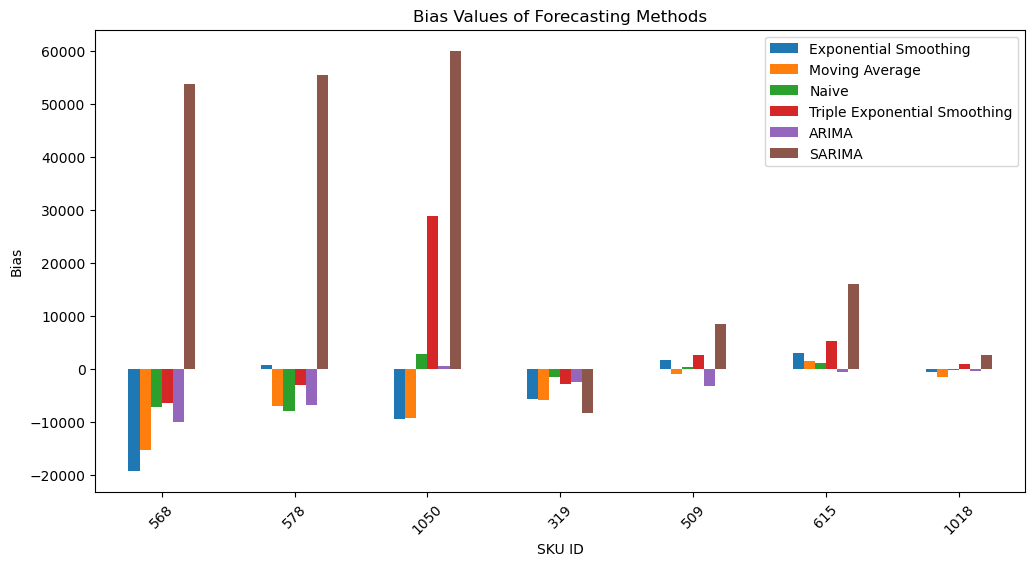

In [115]:
# Plot bias values of the forecasting methods
plt.figure(figsize=(12, 6))
all_forecasts_bias.plot(kind='bar', figsize=(12, 6))
plt.title('Bias Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('Bias')
plt.xticks(rotation=45)
plt.show()


## MAPE = (|Actual - Forecasted| / Actual) / n

MAPE is the average of the absolute percentage differences between the forecasted values and the actual values. It is a measure of the prediction accuracy of a forecasting method. The lower the MAPE value, the more accurate the forecasting method is.

In [116]:
all_forecasts_mape = pd.concat([exponential_smoothing_forecast['mape'], moving_average_forecast['mape'], naive_forecast['mape'], triple_exponential_smoothing_forecast['mape'], arima_forecast['mape'], sarima_forecast['mape']], axis=1)
all_forecasts_mape.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']
all_forecasts_mape

Exponential Smoothing  Moving Average  Naive  \
sku_id                                                 
568                     0.181           0.198  0.209   
578                     0.134           0.187  0.191   
1050                    0.123           0.116  0.091   
319                     0.079           0.121  0.130   
509                     0.060           0.086  0.089   
615                     0.124           0.129  0.128   
1018                    0.076           0.118  0.128   

        Triple Exponential Smoothing  ARIMA  SARIMA  
sku_id                                               
568                            0.206  0.206   0.407  
578                            0.091  0.186   0.699  
1050                           0.370  0.075   0.758  
319                            0.079  0.128   0.126  
509                            0.075  0.088   0.244  
615                            0.164  0.121   0.486  
1018                           0.085  0.125   0.161

<Figure size 1200x600 with 0 Axes>

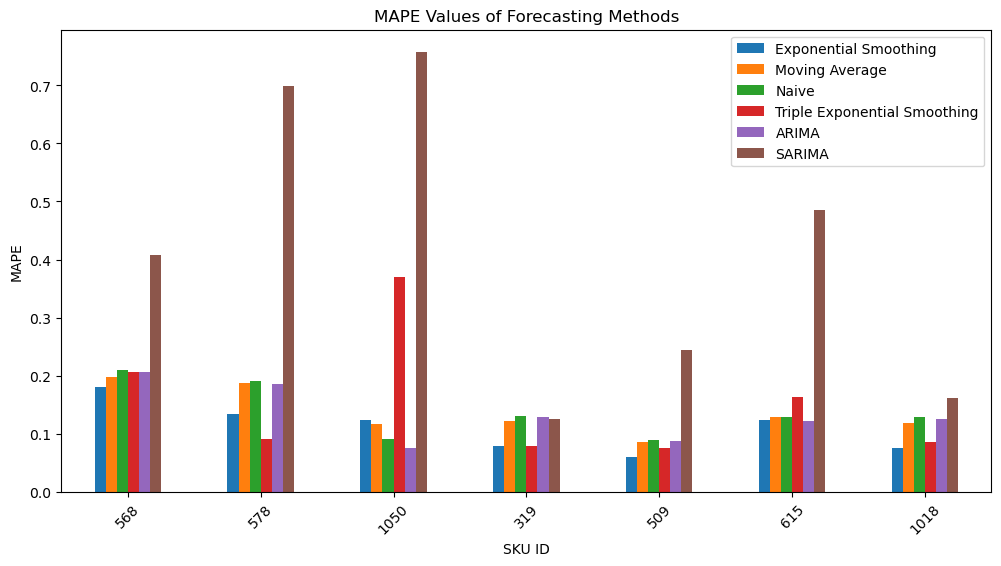

In [117]:
# Plot MAPE values of the forecasting methods
plt.figure(figsize=(12, 6))
all_forecasts_mape.plot(kind='bar', figsize=(12, 6))
plt.title('MAPE Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('MAPE')
plt.xticks(rotation=45)
plt.show()

## MAD = |Actual - Forecasted| / n

MAD is the average of the absolute differences between the forecasted values and the actual values. It is a measure of the accuracy of the forecasting method. The lower the MAD value, the more accurate the forecasting method is.

In [118]:
all_forecasts_mad = pd.concat([exponential_smoothing_forecast['mad'], moving_average_forecast['mad'], naive_forecast['mad'], triple_exponential_smoothing_forecast['mad'], arima_forecast['mad'], sarima_forecast['mad']], axis=1)

all_forecasts_mad.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']
all_forecasts_mad

Exponential Smoothing  Moving Average     Naive  \
sku_id                                                    
568                  32362.00        34351.25  34351.25   
578                  11274.00        16069.50  16531.00   
1050                  9405.50         9811.75   6983.25   
319                   5668.25         8278.00   8278.00   
509                   2155.00         3032.00   3032.00   
615                   3861.75         4051.75   4051.75   
1018                  1373.50         2174.75   2174.75   

        Triple Exponential Smoothing     ARIMA    SARIMA  
sku_id                                                    
568                         33163.75  34387.50  53753.50  
578                          8300.00  15985.00  55476.25  
1050                        28716.50   5859.00  59987.75  
319                          5248.00   8269.75   8360.50  
509                          2592.50   3281.50   8373.25  
615                          5286.00   4034.75  15970.75  
1018                         1323.25   2166.75   2536.25

<Figure size 1200x600 with 0 Axes>

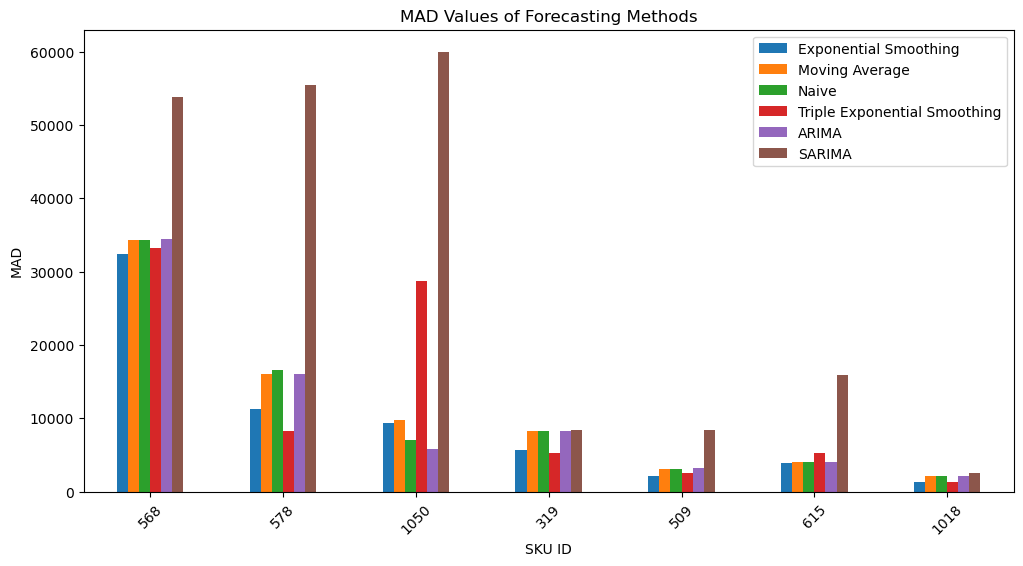

In [119]:
# Plot MAD values of the forecasting methods
plt.figure(figsize=(12, 6))
all_forecasts_mad.plot(kind='bar', figsize=(12, 6))
plt.title('MAD Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('MAD')
plt.xticks(rotation=45)
plt.show()

## All Metrics Comparison

In [120]:
all_forecasts = pd.concat([exponential_smoothing_forecast, moving_average_forecast, naive_forecast, triple_exponential_smoothing_forecast, arima_forecast, sarima_forecast], axis=1)
all_forecasts

mape           mse       rmse      bias       mad   mape  \
sku_id                                                              
568     0.181  1.533941e+09  39165.555 -19257.00  32362.00  0.198   
578     0.134  1.706804e+08  13064.470    758.50  11274.00  0.187   
1050    0.123  1.031907e+08  10158.281  -9405.50   9405.50  0.116   
319     0.079  8.609675e+07   9278.834  -5668.25   5668.25  0.121   
509     0.060  7.612652e+06   2759.103   1560.00   2155.00  0.086   
615     0.124  2.088601e+07   4570.121   2976.75   3861.75  0.129   
1018    0.076  2.577900e+06   1605.584   -659.00   1373.50  0.118   

                 mse       rmse      bias       mad  ...   mape           mse  \
sku_id                                               ...                        
568     1.947829e+09  44134.211 -15368.25  34351.25  ...  0.206  1.815430e+09   
578     3.642370e+08  19084.995  -7037.00  16069.50  ...  0.186  3.613693e+08   
1050    1.452260e+08  12050.975  -9349.25   9811.75  ...  0.075  5.815663e+07   
319     1.288461e+08  11351.038  -5909.50   8278.00  ...  0.128  1.000076e+08   
509     1.090382e+07   3302.094   -971.50   3032.00  ...  0.088  1.961854e+07   
615     2.209720e+07   4700.766   1482.25   4051.75  ...  0.121  1.885622e+07   
1018    7.078773e+06   2660.596  -1502.25   2174.75  ...  0.125  5.015902e+06   

             rmse      bias       mad   mape           mse       rmse  \
sku_id                                                                  
568     42607.865 -10106.00  34387.50  0.407  4.154596e+09  64456.156   
578     19009.716  -6789.50  15985.00  0.699  3.414105e+09  58430.342   
1050     7626.050    593.00   5859.00  0.758  3.615398e+09  60128.183   
319     10000.378  -2469.75   8269.75  0.126  1.075144e+08  10368.917   
509      4429.282  -3246.00   3281.50  0.244  7.613258e+07   8725.398   
615      4342.375   -714.75   4034.75  0.486  2.600438e+08  16125.873   
1018     2239.621   -480.75   2166.75  0.161  8.812714e+06   2968.622   

            bias       mad  
sku_id                      
568     53753.50  53753.50  
578     55476.25  55476.25  
1050    59987.75  59987.75  
319     -8360.50   8360.50  
509      8373.25   8373.25  
615     15970.75  15970.75  
1018     2536.25   2536.25  

[7 rows x 30 columns]

<Figure size 1200x600 with 0 Axes>

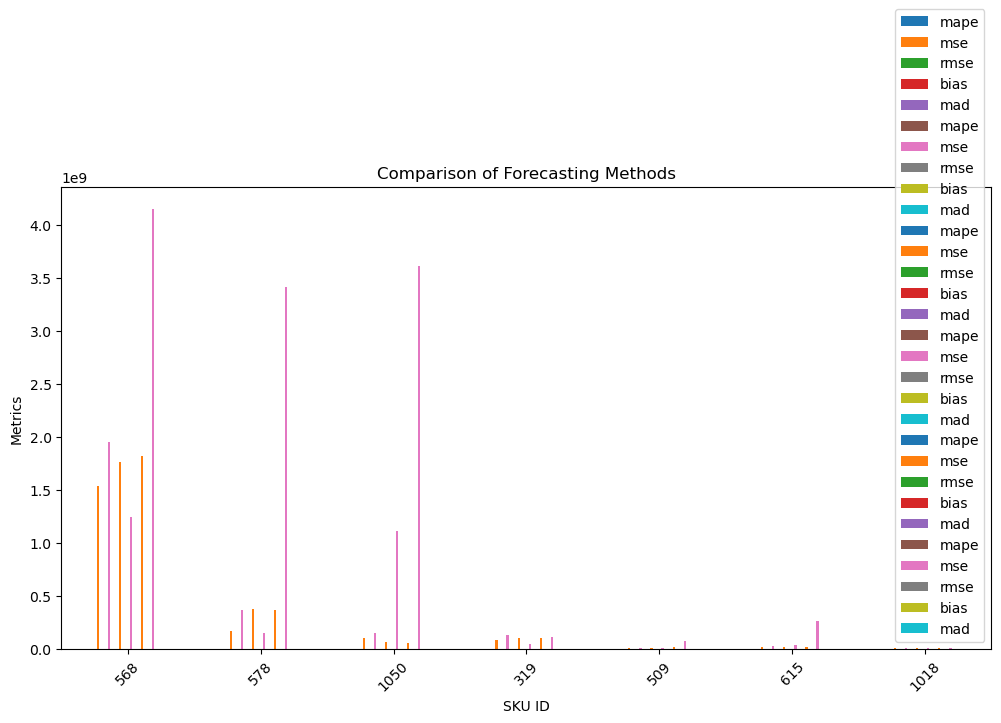

In [121]:
# Plot the comparison of forecasting methods
plt.figure(figsize=(12, 6))
all_forecasts.plot(kind='bar', figsize=(12, 6)) 
plt.title('Comparison of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('Metrics')
plt.xticks(rotation=45)
plt.show()

# Monthly Sales Analysis

Calculate the total sales of the choosen SKU's for monthly. It should be 36 rows in total for every SKU.

In [122]:
monthly_data = data.copy()

monthly_data['Year'] = monthly_data['Date'].dt.year
monthly_data['Month'] = monthly_data['Date'].dt.month

monthly_data = monthly_data.groupby(['Year', 'Month', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
monthly_data

Year  Month SkuID  TotalQuantity
0    2019      1  1018           4559
1    2019      1  1050          19893
2    2019      1   319          16316
3    2019      1   509          13993
4    2019      1   568          54068
..    ...    ...   ...            ...
247  2021     12   319          28037
248  2021     12   509          13327
249  2021     12   568          54617
250  2021     12   578          27257
251  2021     12   615          12425

[252 rows x 4 columns]

In [123]:
# Plot SKU sales for each month

def plot_sku_monthly(sku_id):
    sku = monthly_data[monthly_data['SkuID'] == sku_id]
    plt.figure(figsize=(12, 6))
    plt.plot(sku.index, sku['TotalQuantity'])
    plt.title(f'SKU {sku_id} Total Quantity by Month')
    plt.xlabel('Month')
    plt.ylabel('Total Quantity')
    plt.xticks(rotation=45)
    plt.show()

SKU 568
Year  Month
2019  1         54068
      2         56115
      3         35696
      4         40855
      5         51793
      6         30889
      7         40455
      8         35839
      9         43548
      10        46278
      11        59636
      12        51000
2020  1         71126
      2         45135
      3         37509
      4         36699
      5         44420
      6         50590
      7         42860
      8         44094
      9         51139
      10        70269
      11        42701
      12        41391
2021  1         58456
      2         42867
      3         38653
      4         43395
      5         40054
      6         82478
      7         32898
      8         30591
      9         51023
      10        48319
      11       123030
      12        54617
Name: TotalQuantity, dtype: int64


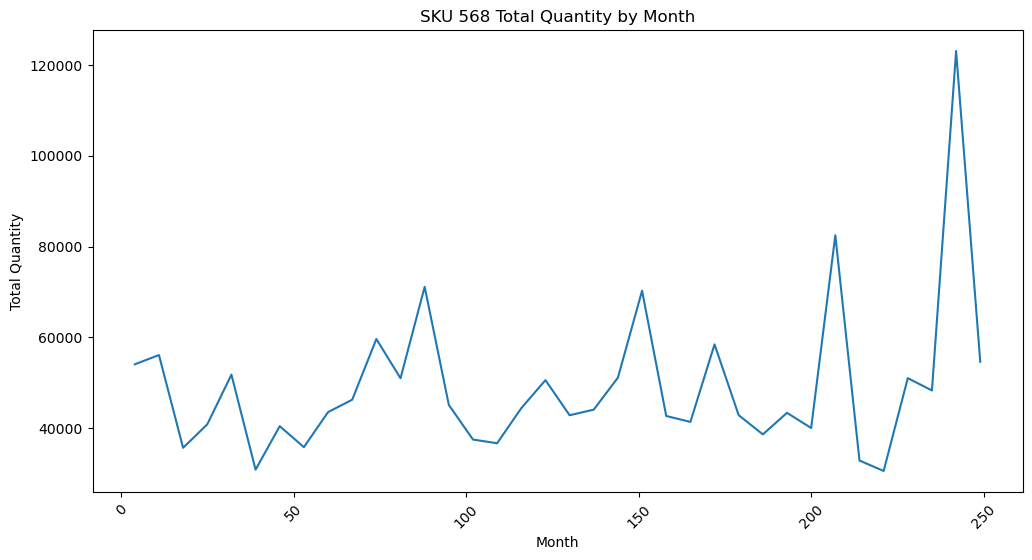

SKU 578
Year  Month
2019  1        35666
      2        39802
      3        27465
      4        33553
      5        30016
      6        26184
      7        26848
      8        22876
      9        27053
      10       33694
      11       30773
      12       33494
2020  1        38044
      2        34863
      3        25678
      4        25633
      5        28195
      6        33705
      7        27462
      8        19633
      9        32799
      10       19690
      11       29633
      12       28724
2021  1        33641
      2        23927
      3        34284
      4        30377
      5        21488
      6        29467
      7        15476
      8        21002
      9        24427
      10       23160
      11       59522
      12       27257
Name: TotalQuantity, dtype: int64


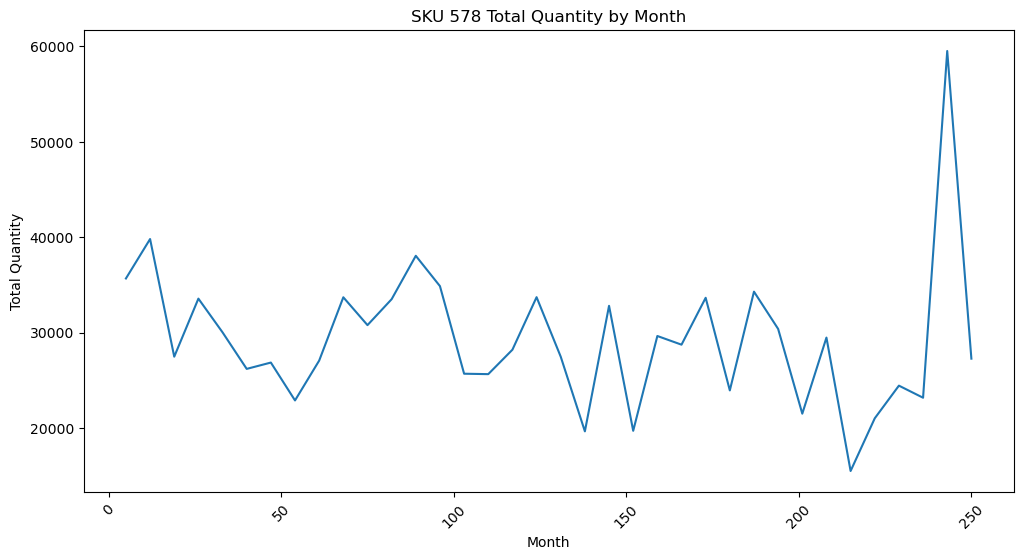

SKU 1050
Year  Month
2019  1        19893
      2        15298
      3        17790
      4        16777
      5        18261
      6        11618
      7        16940
      8        17132
      9        26043
      10       18288
      11       31647
      12       25830
2020  1        54784
      2        14459
      3        29414
      4        27154
      5        31898
      6        28334
      7        15182
      8        19447
      9        23381
      10       32982
      11       20448
      12       28947
2021  1        27512
      2        27942
      3        22815
      4        22999
      5        19766
      6        26503
      7        21951
      8        20913
      9        37094
      10       34359
      11       26593
      12       29722
Name: TotalQuantity, dtype: int64


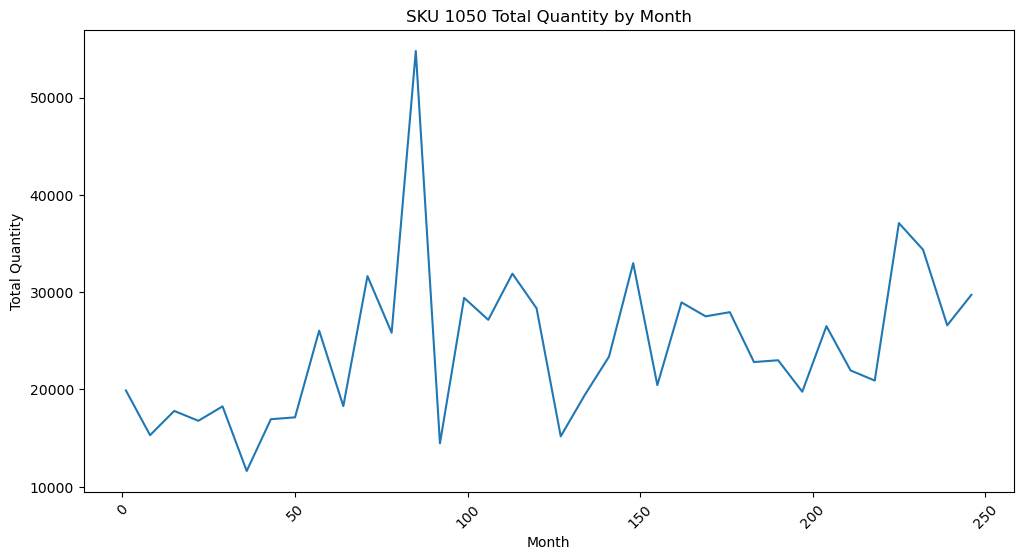

SKU 319
Year  Month
2019  1        16316
      2        16813
      3        13694
      4        14012
      5        16314
      6        12262
      7        14854
      8        13200
      9        14764
      10       15665
      11       16645
      12       17633
2020  1        21996
      2        17211
      3        17259
      4        17299
      5        16052
      6        15822
      7        15129
      8        15004
      9        20708
      10       18154
      11       18771
      12       22409
2021  1        22590
      2        20806
      3        18778
      4        17973
      5        15924
      6        19438
      7        15205
      8        16109
      9        20788
      10       21989
      11       26349
      12       28037
Name: TotalQuantity, dtype: int64


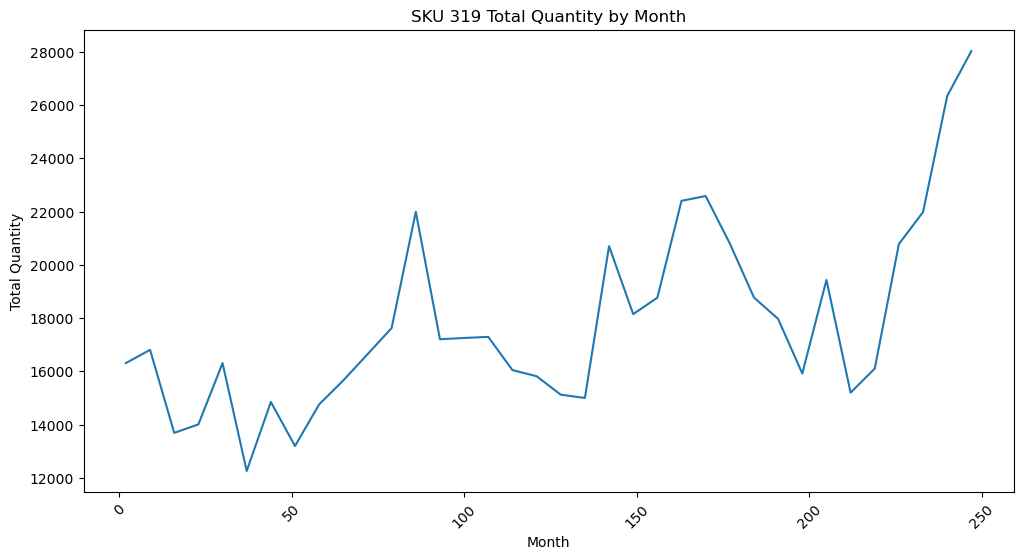

SKU 509
Year  Month
2019  1        13993
      2        13408
      3        15683
      4        10701
      5        12828
      6        11726
      7        10693
      8         8585
      9        11050
      10       11072
      11       11545
      12       13293
2020  1        13762
      2        12131
      3        13177
      4        16035
      5        13774
      6        10564
      7         8945
      8        10448
      9        12982
      10       10441
      11       11564
      12       12866
2021  1        12902
      2        12554
      3        12945
      4        10813
      5         9727
      6        11989
      7         9087
      8         8778
      9        12731
      10       12324
      11       11201
      12       13327
Name: TotalQuantity, dtype: int64


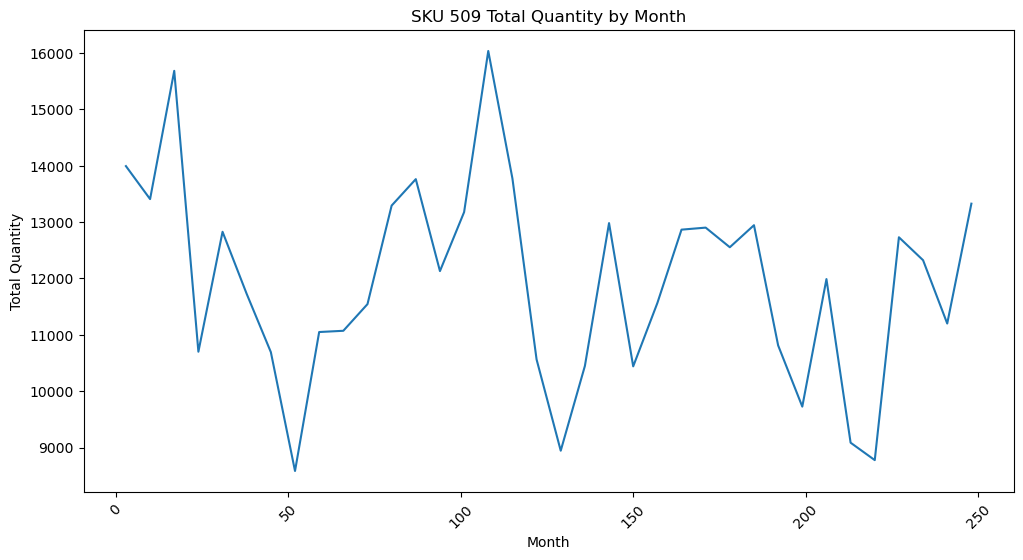

SKU 615
Year  Month
2019  1        11929
      2        13901
      3        11367
      4         9783
      5        12145
      6        10231
      7         9506
      8         7686
      9         9455
      10       11744
      11       10248
      12        9660
2020  1        14921
      2        11332
      3        10113
      4        17199
      5        13219
      6         9179
      7        12133
      8        10295
      9        13538
      10       12495
      11        9427
      12       13085
2021  1        16095
      2        12122
      3        11052
      4        11426
      5         9674
      6        11196
      7         7060
      8         7554
      9        12994
      10       12023
      11       12394
      12       12425
Name: TotalQuantity, dtype: int64


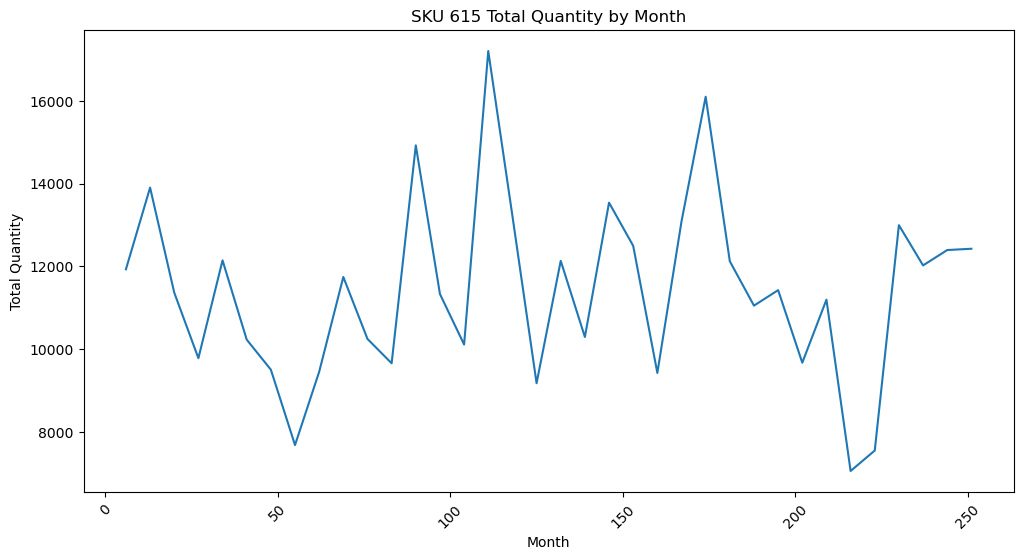

SKU 1018
Year  Month
2019  1        4559
      2        4822
      3        4556
      4        4251
      5        4887
      6        3629
      7        4235
      8        3460
      9        4063
      10       4643
      11       4884
      12       5194
2020  1        6598
      2        5234
      3        4911
      4        6835
      5        5468
      6        4416
      7        3683
      8        4169
      9        6467
      10       4805
      11       5570
      12       6601
2021  1        7145
      2        6714
      3        5576
      4        5188
      5        5011
      6        5191
      7        3765
      8        4199
      9        6595
      10       6168
      11       5995
      12       7050
Name: TotalQuantity, dtype: int64


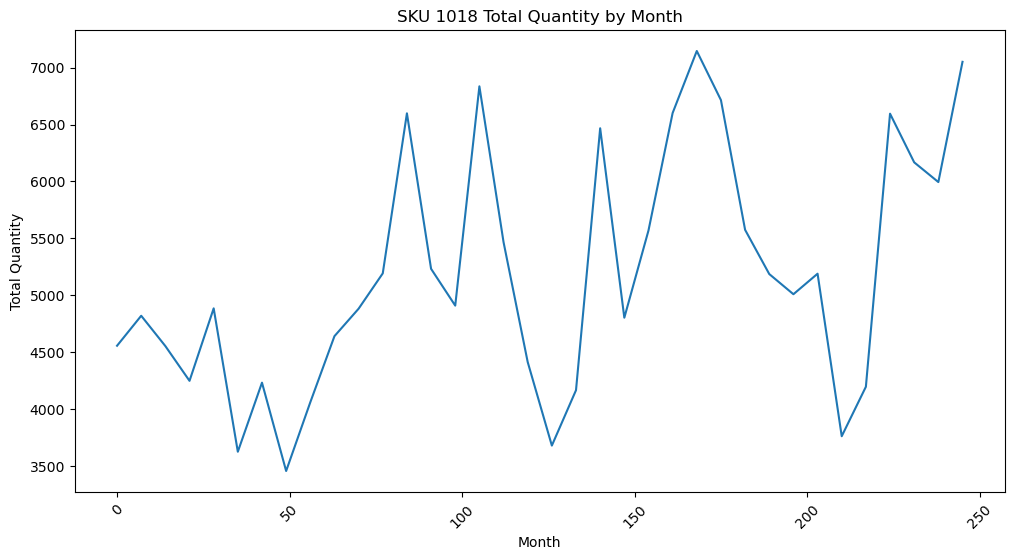

In [124]:
for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    sku_data.set_index(['Year', 'Month'], inplace=True)
    print(sku_data['TotalQuantity'])
    plot_sku_monthly(sku_id)

SKU 568


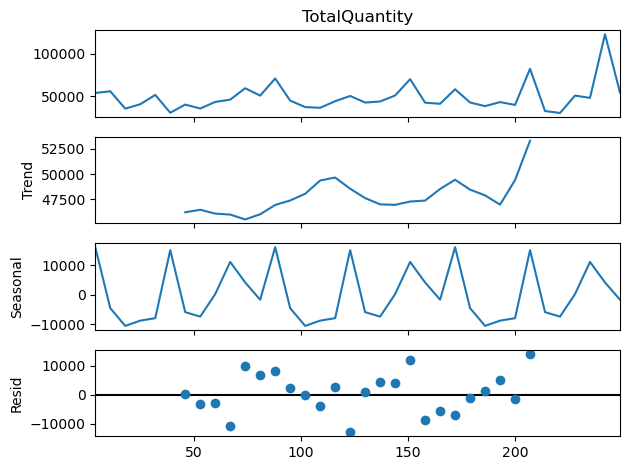

SKU 578


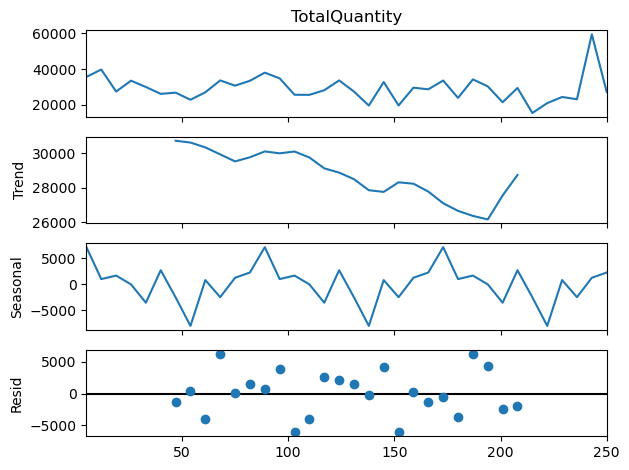

SKU 1050


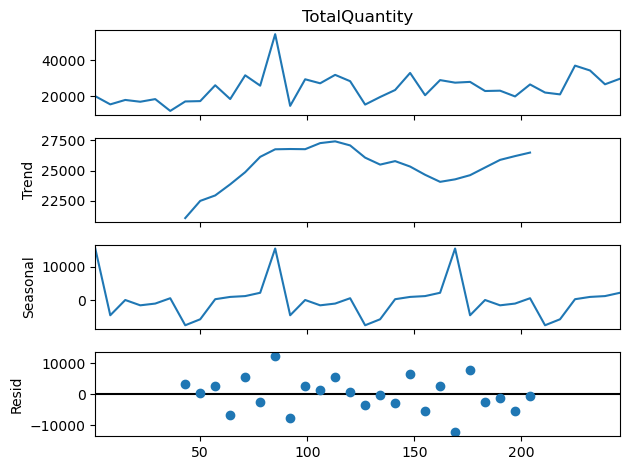

SKU 319


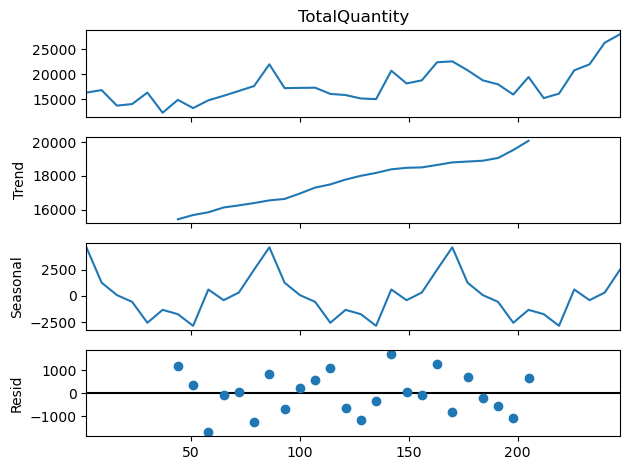

SKU 509


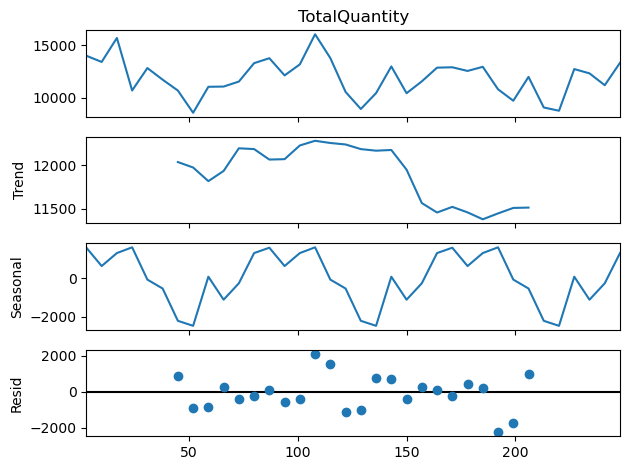

SKU 615


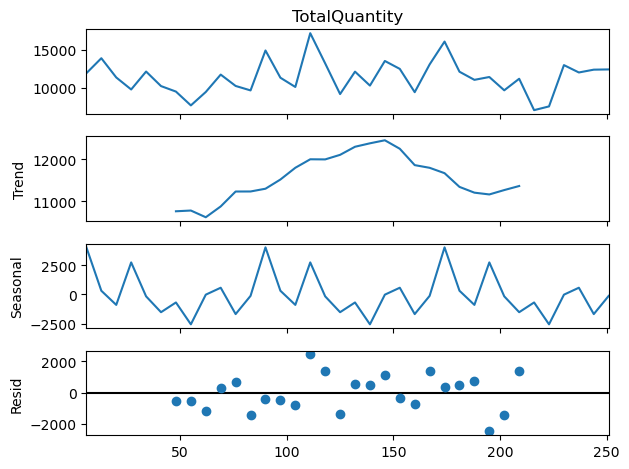

SKU 1018


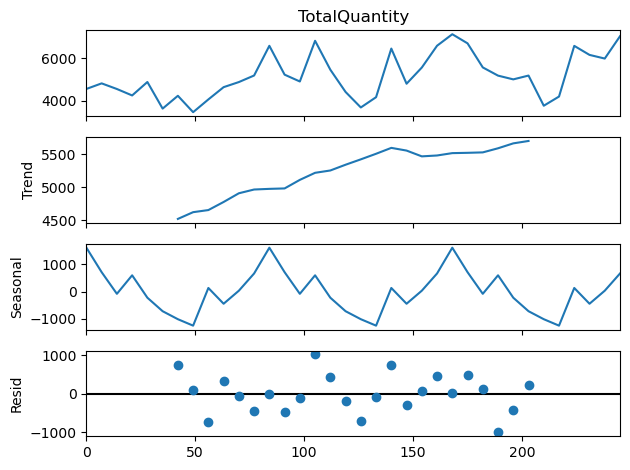

In [125]:
from statsmodels.tsa.seasonal import seasonal_decompose

for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    result = seasonal_decompose(sku_data['TotalQuantity'], model='additive', period=12)
    result.plot()
    plt.show()

In [126]:
monthly_data.set_index(['Year', 'Month'], inplace=True)
monthly_data

SkuID  TotalQuantity
Year Month                     
2019 1      1018           4559
     1      1050          19893
     1       319          16316
     1       509          13993
     1       568          54068
...          ...            ...
2021 12      319          28037
     12      509          13327
     12      568          54617
     12      578          27257
     12      615          12425

[252 rows x 2 columns]

## Forecasting

### Exponential Smoothing

In [127]:
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

exponential_smoothing_forecast_monthly = []

def forecast_sku_ExponentialSmoothing_monthly(sku_id):
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-12]
    validation = sku_data['TotalQuantity'][-12:]
    
    # Train the model
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12, trend='add').fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(12)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 12 months
    full_model = ExponentialSmoothing(sku_data['TotalQuantity'], seasonal='add', seasonal_periods=12, trend='add').fit()
    future_forecast = full_model.forecast(12)
    future_forecast = future_forecast.astype(int)
    
    forecast_months = [(2021, i) for i in range(1, 13)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, month in forecast_months], 
        'Month': [month for year, month in forecast_months], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Month'], inplace=True)
    
    # Append results including validation metrics
    exponential_smoothing_forecast_monthly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })
    
    print(f'SKU {sku_id} Exponential Smoothing Forecast for Next 12 Months\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'Bias: {bias}')
    print('===============\n')


In [128]:
for sku_id in all_sku_ids:
    forecast_sku_ExponentialSmoothing_monthly(sku_id)

SKU 568 Exponential Smoothing Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           71987
     2           51764
     3           46095
     4           48162
     5           49288
     6           72483
     7           51916
     8           50708
     9           58599
     10          69711
     11          63105
     12          57594

MAPE: 0.19136650060570337
MSE: 439732463.3476496
RMSE: 20969.798838988645
Bias: -4519.619936586668

SKU 578 Exponential Smoothing Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           34735
     2           28484
     3           29081
     4           27299
     5           23676
     6           29869
     7           24554
     8           18947
     9           27726
     10          24335
     11          28013
     12          28944

MAPE: 0.2450073123329066
MSE: 114281945.43236214
RMSE: 10690.273403068892
Bias: -570.5297447417042

SKU 1050 Exponential Smoothing Forec

In [129]:
exponential_smoothing_forecast_monthly = pd.DataFrame(exponential_smoothing_forecast_monthly)
exponential_smoothing_forecast_monthly.set_index('sku_id', inplace=True)
exponential_smoothing_forecast_monthly

mape           mse       rmse      bias
sku_id                                          
568     0.191  4.397325e+08  20969.799 -4519.620
578     0.245  1.142819e+08  10690.273  -570.530
1050    0.381  1.418400e+08  11909.658  6285.284
319     0.112  8.316849e+06   2883.895  -455.360
509     0.134  4.489777e+06   2118.909   874.503
615     0.229  9.846970e+06   3137.988  1987.876
1018    0.142  8.997108e+05    948.531   573.284

### Moving Average

In [130]:
moving_average_forecast_monthly = []

def moving_average_forecast(series, window):
    return series.rolling(window=window).mean().iloc[-1]

def forecast_sku_MovingAverage_monthly(sku_id, window=12):
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-12]
    validation = sku_data['TotalQuantity'][-12:]
    
    # Calculate moving average forecast for the validation period
    validation_forecast = np.full(12, moving_average_forecast(train, window))
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast)
    
    # Calculate moving average forecast for the next 12 months
    future_forecast = np.full(12, moving_average_forecast(sku_data['TotalQuantity'], window)).astype(int)
    
    forecast_months = [(2021, i) for i in range(1, 13)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, month in forecast_months], 
        'Month': [month for year, month in forecast_months], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Month'], inplace=True)
    
    # Append results including validation metrics
    moving_average_forecast_monthly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })
    
    print(f'SKU {sku_id} Moving Average Forecast for Next 12 Months\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'Bias: {bias}')
    print('===============\n')


In [131]:
for sku_id in all_sku_ids:
    forecast_sku_MovingAverage_monthly(sku_id)

SKU 568 Moving Average Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           53865
     2           53865
     3           53865
     4           53865
     5           53865
     6           53865
     7           53865
     8           53865
     9           53865
     10          53865
     11          53865
     12          53865

MAPE: 0.25819317803897024
MSE: 640618832.0763888
RMSE: 25310.44906903844
Bias: -5703.999999999997

SKU 578 Moving Average Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           28669
     2           28669
     3           28669
     4           28669
     5           28669
     6           28669
     7           28669
     8           28669
     9           28669
     10          28669
     11          28669
     12          28669

MAPE: 0.2605779811799476
MSE: 114078301.50694443
RMSE: 10680.744426627969
Bias: 2.5833333333321207

SKU 1050 Moving Average Forecast for Next 12 Months

In [132]:
moving_average_forecast_monthly = pd.DataFrame(moving_average_forecast_monthly)
moving_average_forecast_monthly.set_index('sku_id', inplace=True)
moving_average_forecast_monthly

mape           mse       rmse      bias
sku_id                                          
568     0.258  6.406188e+08  25310.449 -5704.000
578     0.261  1.140783e+08  10680.744     2.583
1050    0.162  2.635548e+07   5133.759   688.417
319     0.157  2.019300e+07   4493.662 -2347.667
509     0.125  2.801403e+06   1673.739   692.583
615     0.187  6.182449e+06   2486.453   910.083
1018    0.166  1.189992e+06   1090.868  -320.000

### Naive

In [133]:
naive_forecast_monthly = []

def forecast_sku_Naive_monthly(sku_id):
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-12]
    validation = sku_data['TotalQuantity'][-12:]
    
    # Use the last observed value in the training set to forecast the validation period
    last_observed_value = train.iloc[-1]
    validation_forecast = np.full(12, last_observed_value)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast)
    
    # Use the last observed value in the entire dataset to forecast the next 12 months
    last_observed_value_full = sku_data['TotalQuantity'].iloc[-1]
    future_forecast = np.full(12, last_observed_value_full).astype(int)
    
    forecast_months = [(2021, i) for i in range(1, 13)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, month in forecast_months], 
        'Month': [month for year, month in forecast_months], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Month'], inplace=True)
    naive_forecast_monthly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })
    
    print(f'SKU {sku_id} Naive Forecast for Next 12 Months\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'Bias: {bias}')
    print('===============\n')


In [134]:
for sku_id in all_sku_ids:
    forecast_sku_Naive_monthly(sku_id)

SKU 568 Naive Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           54617
     2           54617
     3           54617
     4           54617
     5           54617
     6           54617
     7           54617
     8           54617
     9           54617
     10          54617
     11          54617
     12          54617

MAPE: 0.2353339542872306
MSE: 763685971.0833334
RMSE: 27634.86875458853
Bias: -12474.083333333334

SKU 578 Naive Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           27257
     2           27257
     3           27257
     4           27257
     5           27257
     6           27257
     7           27257
     8           27257
     9           27257
     10          27257
     11          27257
     12          27257

MAPE: 0.2613590590866308
MSE: 114081319.83333333
RMSE: 10680.88572325972
Bias: 55.0

SKU 1050 Naive Forecast for Next 12 Months

            Forecasted
Year Month       

In [135]:
naive_forecast_monthly = pd.DataFrame(naive_forecast_monthly)
naive_forecast_monthly.set_index('sku_id', inplace=True)
naive_forecast_monthly

mape           mse       rmse       bias
sku_id                                           
568     0.235  7.636860e+08  27634.869 -12474.083
578     0.261  1.140813e+08  10680.886     55.000
1050    0.197  3.180065e+07   5639.206   2432.917
319     0.200  1.899469e+07   4358.290   2076.833
509     0.145  4.102622e+06   2025.493   1334.500
615     0.242  8.418156e+06   2901.406   1750.417
1018    0.225  1.870080e+06   1367.509    884.583

## Seasonal Forecasting Methods

There are seasonal patterns in the monthly data. So, we can use forecasting methods that can capture the seasonality.
- Triple Exponential Smoothing
- ARIMA
- SARIMA

### Triple Exponential Smoothing

In [136]:
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

triple_exponential_smoothing_forecast_monthly = []

def forecast_sku_TripleExponentialSmoothing_monthly(sku_id):
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-12]
    validation = sku_data['TotalQuantity'][-12:]
    
    # Train the model
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12, trend='add').fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(12)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 12 months
    full_model = ExponentialSmoothing(sku_data['TotalQuantity'], seasonal='add', seasonal_periods=12, trend='add').fit()
    future_forecast = full_model.forecast(12)
    future_forecast = future_forecast.astype(int)
    
    forecast_months = [(2021, i) for i in range(1, 13)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, month in forecast_months], 
        'Month': [month for year, month in forecast_months], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Month'], inplace=True)
    
    # Append results including validation metrics
    triple_exponential_smoothing_forecast_monthly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })
    
    print(f'SKU {sku_id} Triple Exponential Smoothing Forecast for Next 12 Months\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'Bias: {bias}')
    print('===============\n')


In [137]:
for sku_id in all_sku_ids:
    forecast_sku_TripleExponentialSmoothing_monthly(sku_id)

SKU 568 Triple Exponential Smoothing Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           71987
     2           51764
     3           46095
     4           48162
     5           49288
     6           72483
     7           51916
     8           50708
     9           58599
     10          69711
     11          63105
     12          57594

MAPE: 0.19136650060570337
MSE: 439732463.3476496
RMSE: 20969.798838988645
Bias: -4519.619936586668

SKU 578 Triple Exponential Smoothing Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           34735
     2           28484
     3           29081
     4           27299
     5           23676
     6           29869
     7           24554
     8           18947
     9           27726
     10          24335
     11          28013
     12          28944

MAPE: 0.2450073123329066
MSE: 114281945.43236214
RMSE: 10690.273403068892
Bias: -570.5297447417042

SKU 1050 Triple Expone

In [138]:
triple_exponential_smoothing_forecast_monthly = pd.DataFrame(triple_exponential_smoothing_forecast_monthly)
triple_exponential_smoothing_forecast_monthly.set_index('sku_id', inplace=True)
triple_exponential_smoothing_forecast_monthly

mape           mse       rmse      bias
sku_id                                          
568     0.191  4.397325e+08  20969.799 -4519.620
578     0.245  1.142819e+08  10690.273  -570.530
1050    0.381  1.418400e+08  11909.658  6285.284
319     0.112  8.316849e+06   2883.895  -455.360
509     0.134  4.489777e+06   2118.909   874.503
615     0.229  9.846970e+06   3137.988  1987.876
1018    0.142  8.997108e+05    948.531   573.284

### ARIMA

In [139]:
from statsmodels.tsa.arima.model import ARIMA

def forecast_sku_ARIMA_monthly(sku_id):
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-12]
    validation = sku_data['TotalQuantity'][-12:]
    
    # Train the model
    model = ARIMA(train, order=(5,1,0)).fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(steps=12)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 12 months
    full_model = ARIMA(sku_data['TotalQuantity'], order=(5,1,0)).fit()
    future_forecast = full_model.forecast(steps=12)
    future_forecast = future_forecast.astype(int)
    
    forecast_months = [(2021, i) for i in range(1, 13)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, month in forecast_months], 
        'Month': [month for year, month in forecast_months], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Month'], inplace=True)
    
    # Append results including validation metrics
    arima_forecast_monthly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })
    
    print(f'SKU {sku_id} ARIMA Forecast for Next 12 Months\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'Bias: {bias}')
    print('===============\n')

In [140]:
arima_forecast_monthly = []

for sku_id in all_sku_ids:
    forecast_sku_ARIMA_monthly(sku_id)

SKU 568 ARIMA Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           43530
     2           60101
     3           55553
     4           89488
     5           63001
     6           52533
     7           62646
     8           59897
     9           74672
     10          65001
     11          57928
     12          63315

MAPE: 0.26298060380010807
MSE: 646797138.1892462
RMSE: 25432.206710964863
Bias: -5855.771106079611

SKU 578 ARIMA Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           30516
     2           33194
     3           24381
     4           36065
     5           34406
     6           31220
     7           34083
     8           30610
     9           31618
     10          33183
     11          31912
     12          32784

MAPE: 0.24486973692142103
MSE: 123163235.8511196
RMSE: 11097.893306890259
Bias: -2352.5342462308586

SKU 1050 ARIMA Forecast for Next 12 Months

            Forecasted


In [141]:
arima_forecast_monthly = pd.DataFrame(arima_forecast_monthly)
arima_forecast_monthly.set_index('sku_id', inplace=True)
arima_forecast_monthly

mape           mse       rmse      bias
sku_id                                          
568     0.263  6.467971e+08  25432.207 -5855.771
578     0.245  1.231632e+08  11097.893 -2352.534
1050    0.162  2.614518e+07   5113.236    45.087
319     0.157  1.463098e+07   3825.046   307.086
509     0.133  3.350475e+06   1830.430  1017.596
615     0.181  5.362815e+06   2315.775   789.261
1018    0.181  1.187968e+06   1089.939   263.085

### SARIMA

In [142]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def forecast_sku_SARIMA_monthly(sku_id):
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-12]
    validation = sku_data['TotalQuantity'][-12:]
    
    # Train the model
    model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
    
    # Forecast for the validation period
    validation_forecast = model.get_forecast(steps=12).predicted_mean
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 12 months
    full_model = SARIMAX(sku_data['TotalQuantity'], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
    future_forecast = full_model.get_forecast(steps=12).predicted_mean
    future_forecast = future_forecast.astype(int)
    
    forecast_months = [(2021, i) for i in range(1, 13)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, month in forecast_months], 
        'Month': [month for year, month in forecast_months], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Month'], inplace=True)
    
    # Append results including validation metrics
    sarima_forecast_monthly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })
    
    print(f'SKU {sku_id} SARIMA Forecast for Next 12 Months\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'Bias: {bias}')
    print('===============\n')

In [143]:
sarima_forecast_monthly = []

for sku_id in all_sku_ids:
    forecast_sku_SARIMA_monthly(sku_id)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28968D+00    |proj g|=  4.71928D-01

At iterate    5    f=  5.01887D+00    |proj g|=  4.41329D-02

At iterate   10    f=  4.98286D+00    |proj g|=  2.68556D-03

At iterate   15    f=  4.98101D+00    |proj g|=  2.73021D-03

At iterate   20    f=  4.97898D+00    |proj g|=  2.06738D-03

At iterate   25    f=  4.97854D+00    |proj g|=  4.61963D-04

At iterate   30    f=  4.97848D+00    |proj g|=  1.78522D-04

At iterate   35    f=  4.97806D+00    |proj g|=  7.66258D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  7.33497D+00    |proj g|=  1.09663D-02

At iterate   10    f=  7.33412D+00    |proj g|=  3.36066D-04

At iterate   15    f=  7.33412D+00    |proj g|=  3.92085D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   8.961D-06   7.334D+00
  F =   7.3341157303395939     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SKU 568 SARIMA Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1          113676
     2           72645
     3           77692
     4           72387
     5           80179
     6           95315
     7   

 This problem is unconstrained.


At iterate    5    f=  4.70032D+00    |proj g|=  2.24577D-02

At iterate   10    f=  4.68461D+00    |proj g|=  2.42371D-02

At iterate   15    f=  4.67689D+00    |proj g|=  7.02989D-03

At iterate   20    f=  4.67505D+00    |proj g|=  1.08153D-03

At iterate   25    f=  4.67471D+00    |proj g|=  1.99830D-04

At iterate   30    f=  4.67464D+00    |proj g|=  4.47305D-04

At iterate   35    f=  4.67418D+00    |proj g|=  2.65108D-03

At iterate   40    f=  4.67050D+00    |proj g|=  3.11852D-02

At iterate   45    f=  4.66629D+00    |proj g|=  5.89023D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     70    

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92335D+00    |proj g|=  2.80729D-01

At iterate    5    f=  6.84894D+00    |proj g|=  9.07830D-03

At iterate   10    f=  6.84847D+00    |proj g|=  3.14643D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   1.131D-05   6.848D+00
  F =   6.8484397240500163     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SKU 578 SARIMA Forecast for Next 12 Months

            Forecasted
Yea

 This problem is unconstrained.



At iterate    5    f=  4.85321D+00    |proj g|=  1.08218D-02

At iterate   10    f=  4.84724D+00    |proj g|=  2.58109D-03

At iterate   15    f=  4.84541D+00    |proj g|=  1.01016D-03

At iterate   20    f=  4.84510D+00    |proj g|=  1.60356D-03

At iterate   25    f=  4.84502D+00    |proj g|=  9.40925D-05

At iterate   30    f=  4.84501D+00    |proj g|=  2.45689D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     40      1     0     0   1.002D-03   4.845D+00
  F =   4.8450011785600768     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  6.73908D+00    |proj g|=  2.09806D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     20      1     0     0   2.098D-05   6.739D+00
  F =   6.7390835193817864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SKU 1050 SARIMA Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           50052
     2           28204
     3           35892
     4           34486
     5           36895
     6           34182
     7           28309
     8           30408
     9           36581
     10          39203
     11          35196
     12          

 This problem is unconstrained.



At iterate   25    f=  4.20972D+00    |proj g|=  3.41528D-04

At iterate   30    f=  4.20882D+00    |proj g|=  1.30780D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     44      1     0     0   1.304D-04   4.209D+00
  F =   4.2088228470378057     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.09591D+00    |proj g|=  3.68914D-01


 This problem is unconstrained.



At iterate    5    f=  6.00431D+00    |proj g|=  8.77267D-02

At iterate   10    f=  5.97090D+00    |proj g|=  7.02649D-03

At iterate   15    f=  5.96684D+00    |proj g|=  3.44221D-03

At iterate   20    f=  5.96610D+00    |proj g|=  8.10993D-04

At iterate   25    f=  5.96598D+00    |proj g|=  1.03779D-04

At iterate   30    f=  5.96596D+00    |proj g|=  1.04532D-04

At iterate   35    f=  5.96595D+00    |proj g|=  2.86105D-04

At iterate   40    f=  5.96577D+00    |proj g|=  5.54577D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     50      1     0     0   2.918D-06   5.966D+00
  F =   5.96577081007

 This problem is unconstrained.



At iterate   10    f=  4.15240D+00    |proj g|=  9.18548D-03

At iterate   15    f=  4.13575D+00    |proj g|=  1.65468D-03

At iterate   20    f=  4.13368D+00    |proj g|=  1.18719D-03

At iterate   25    f=  4.12445D+00    |proj g|=  2.54102D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     29      1     0     0   5.402D-06   4.124D+00
  F =   4.1244392358119297     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  5.83314D+00    |proj g|=  1.80157D-02

At iterate   10    f=  5.81588D+00    |proj g|=  4.16507D-02

At iterate   15    f=  5.81320D+00    |proj g|=  2.54396D-03

At iterate   20    f=  5.81135D+00    |proj g|=  1.86728D-03

At iterate   25    f=  5.81134D+00    |proj g|=  2.38881D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     38      1     0     0   2.389D-05   5.811D+00
  F =   5.8113417042075373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SKU 509 SARIMA Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           15858


 This problem is unconstrained.



At iterate    5    f=  4.28062D+00    |proj g|=  2.63604D-02

At iterate   10    f=  4.26863D+00    |proj g|=  3.90056D-03

At iterate   15    f=  4.26762D+00    |proj g|=  1.32868D-04

At iterate   20    f=  4.26762D+00    |proj g|=  1.87392D-04

At iterate   25    f=  4.26759D+00    |proj g|=  3.37387D-03

At iterate   30    f=  4.26451D+00    |proj g|=  3.63654D-02

At iterate   35    f=  4.24953D+00    |proj g|=  2.83205D-03

At iterate   40    f=  4.24808D+00    |proj g|=  2.97511D-03


 This problem is unconstrained.


  ys=-1.276E-03  -gs= 6.306E-04 BFGS update SKIPPED

At iterate   45    f=  4.24556D+00    |proj g|=  1.38986D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     65      1     1     0   7.991D-06   4.245D+00
  F =   4.2452816043266184     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16773D+00    |proj g|=  4.12277D-01

At iterate    5    f=  6.01820D+00    |proj g|=  1.26471D-02

At iterate   10  

 This problem is unconstrained.



At iterate    5    f=  3.91465D+00    |proj g|=  1.26819D-02

At iterate   10    f=  3.91144D+00    |proj g|=  2.10805D-03

At iterate   15    f=  3.91104D+00    |proj g|=  4.64551D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   7.858D-06   3.911D+00
  F =   3.9110392655267767     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.36668D+00    |proj g|=  1.59824D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  5.33200D+00    |proj g|=  8.94547D-05

At iterate   20    f=  5.33199D+00    |proj g|=  1.69556D-03

At iterate   25    f=  5.33015D+00    |proj g|=  1.84515D-02

At iterate   30    f=  5.32587D+00    |proj g|=  2.09616D-03

At iterate   35    f=  5.32521D+00    |proj g|=  4.03710D-03
SKU 1018 SARIMA Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1            7724
     2            7293
     3            6585
     4            6625
     5            6409
     6            6063
     7            5307
     8            5473
     9            7221
     10           6858
     11           6925
     12           7635


At iterate   40    f=  5.32507D+00    |proj g|=  8.64949D-04

At iterate   45    f=  5.32504D+00    |proj g|=  3.08484D-04

At iterate   50    f=  5.32503D+00    |proj g|=  2.30524D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments expl

In [144]:
sarima_forecast_monthly = pd.DataFrame(sarima_forecast_monthly)
sarima_forecast_monthly.set_index('sku_id', inplace=True)
sarima_forecast_monthly

mape           mse       rmse       bias
sku_id                                           
568     0.994  2.062465e+09  45414.367  39194.434
578     1.235  9.858916e+08  31398.910  29386.886
1050    0.760  3.927605e+08  19818.185  18904.444
319     0.835  2.621707e+08  16191.685  15824.033
509     1.145  1.682689e+08  12971.852  12879.224
615     0.980  1.106749e+08  10520.216  10181.283
1018    0.238  1.935525e+06   1391.231   1198.150

# Monthly: Comparison of Forecasting Methods
## Bias Values of Forecasting Methods

Bias = (Actual - Forecasted) / n 

In [145]:
all_forecasts_bias_monthly = pd.concat([exponential_smoothing_forecast_monthly['bias'], moving_average_forecast_monthly['bias'], naive_forecast_monthly['bias'], triple_exponential_smoothing_forecast_monthly['bias'], arima_forecast_monthly['bias'], sarima_forecast_monthly['bias']], axis=1)
all_forecasts_bias_monthly.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']

all_forecasts_bias_monthly

Exponential Smoothing  Moving Average      Naive  \
sku_id                                                     
568                 -4519.620       -5704.000 -12474.083   
578                  -570.530           2.583     55.000   
1050                 6285.284         688.417   2432.917   
319                  -455.360       -2347.667   2076.833   
509                   874.503         692.583   1334.500   
615                  1987.876         910.083   1750.417   
1018                  573.284        -320.000    884.583   

        Triple Exponential Smoothing     ARIMA     SARIMA  
sku_id                                                     
568                        -4519.620 -5855.771  39194.434  
578                         -570.530 -2352.534  29386.886  
1050                        6285.284    45.087  18904.444  
319                         -455.360   307.086  15824.033  
509                          874.503  1017.596  12879.224  
615                         1987.876   789.261  10181.283  
1018                         573.284   263.085   1198.150

<Figure size 1200x600 with 0 Axes>

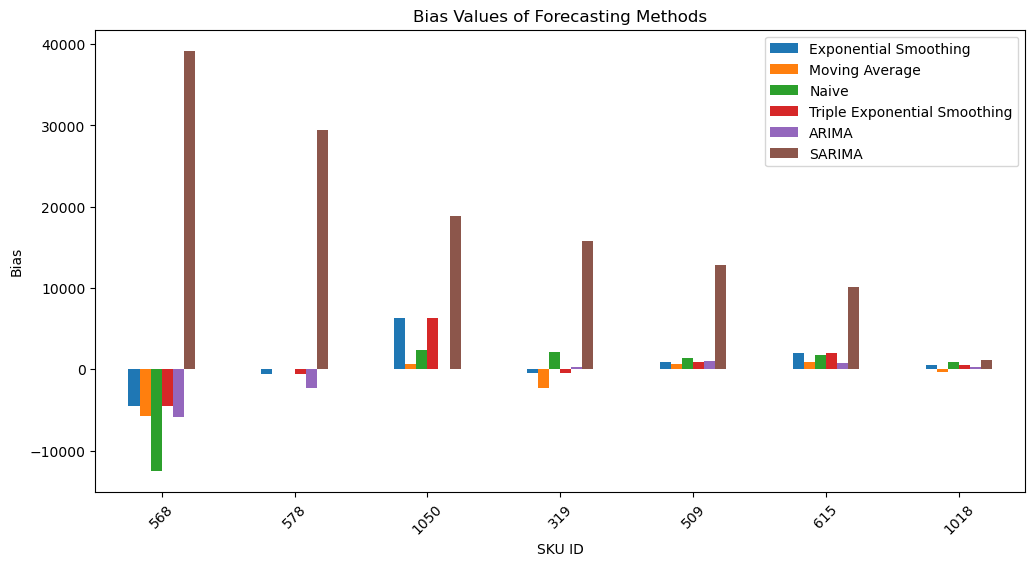

In [146]:
plt.figure(figsize=(12, 6))
all_forecasts_bias_monthly.plot(kind='bar', figsize=(12, 6))
plt.title('Bias Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('Bias')
plt.xticks(rotation=45)
plt.show()

In [147]:
all_forecasts_mape_monthly = pd.concat([exponential_smoothing_forecast_monthly['mape'], moving_average_forecast_monthly['mape'], naive_forecast_monthly['mape'], triple_exponential_smoothing_forecast_monthly['mape'], arima_forecast_monthly['mape'], sarima_forecast_monthly['mape']], axis=1)
all_forecasts_mape_monthly.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']

all_forecasts_mape_monthly

Exponential Smoothing  Moving Average  Naive  \
sku_id                                                 
568                     0.191           0.258  0.235   
578                     0.245           0.261  0.261   
1050                    0.381           0.162  0.197   
319                     0.112           0.157  0.200   
509                     0.134           0.125  0.145   
615                     0.229           0.187  0.242   
1018                    0.142           0.166  0.225   

        Triple Exponential Smoothing  ARIMA  SARIMA  
sku_id                                               
568                            0.191  0.263   0.994  
578                            0.245  0.245   1.235  
1050                           0.381  0.162   0.760  
319                            0.112  0.157   0.835  
509                            0.134  0.133   1.145  
615                            0.229  0.181   0.980  
1018                           0.142  0.181   0.238

## MAPE Values of Forecasting Methods

MAPE = (|Actual - Forecasted| / Actual) / n

<Figure size 1200x600 with 0 Axes>

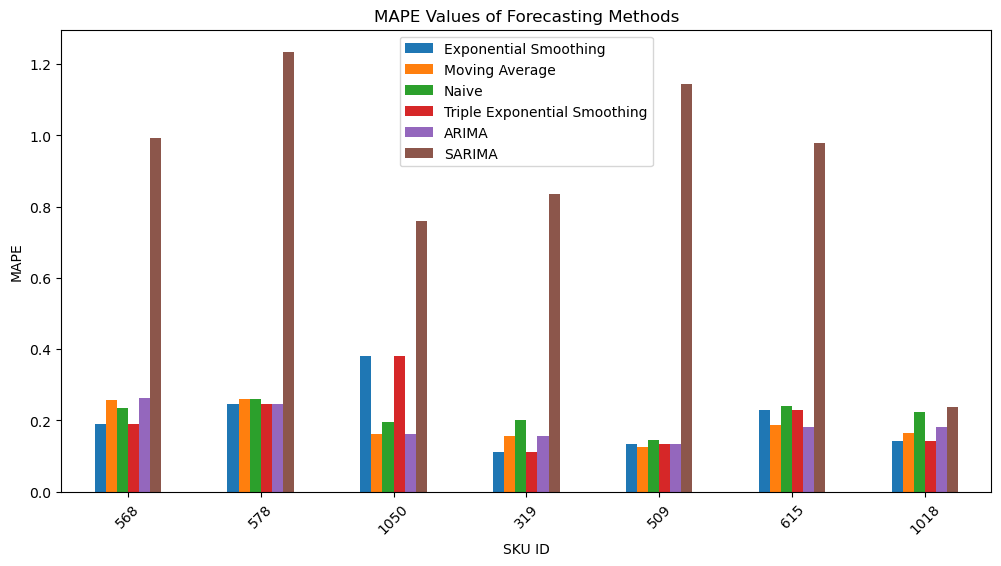

In [148]:
plt.figure(figsize=(12, 6))
all_forecasts_mape_monthly.plot(kind='bar', figsize=(12, 6))
plt.title('MAPE Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('MAPE')
plt.xticks(rotation=45)
plt.show()

# Weekly Sales Analysis and Forecasting

In [149]:
weekly_data = data.copy()

weekly_data['Year'] = weekly_data['Date'].dt.year
weekly_data['Week'] = weekly_data['Date'].dt.isocalendar().week

weekly_data = weekly_data.groupby(['Year', 'Week', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
weekly_data

Year  Week SkuID  TotalQuantity
0     2019     1  1018           1064
1     2019     1  1050           3291
2     2019     1   319           3764
3     2019     1   509           2981
4     2019     1   568          13012
...    ...   ...   ...            ...
1101  2021    53   319            229
1102  2021    53   509             91
1103  2021    53   568             88
1104  2021    53   578             90
1105  2021    53   615             44

[1106 rows x 4 columns]

In [150]:
def plot_sku_weekly(sku_id):
    sku = weekly_data[weekly_data['SkuID'] == sku_id]
    plt.figure(figsize=(12, 6))
    plt.plot(sku.index, sku['TotalQuantity'])
    plt.title(f'SKU {sku_id} Total Quantity by Week')
    plt.xlabel('Week')
    plt.ylabel('Total Quantity')
    plt.xticks(rotation=45)
    plt.show()
    

SKU 568
Year  Week
2019  1       13012
      2       11898
      3       13531
      4        9830
      5       14812
              ...  
2021  49      12268
      50      14154
      51       8820
      52       7648
      53         88
Name: TotalQuantity, Length: 158, dtype: int64


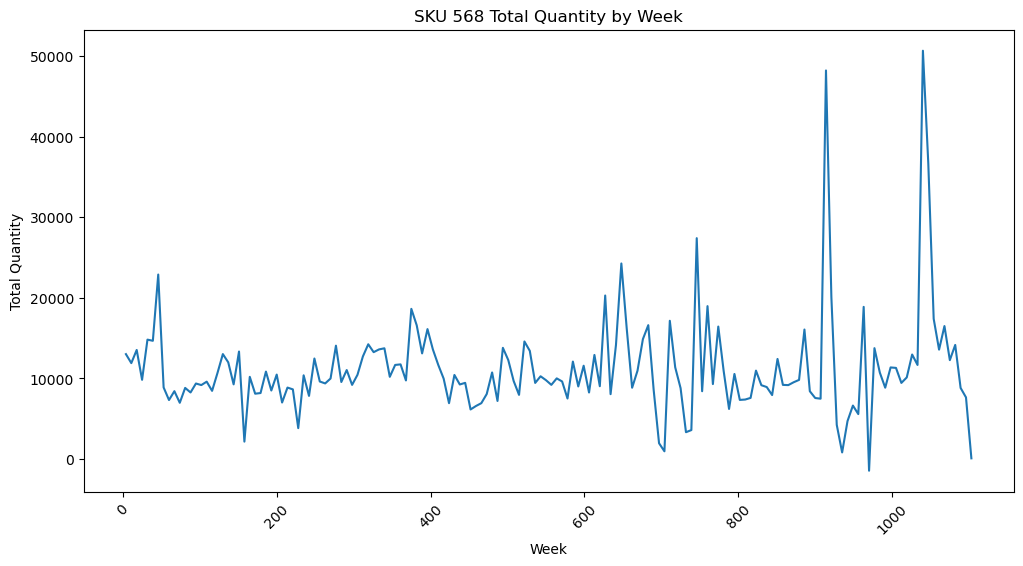

SKU 578
Year  Week
2019  1        7736
      2        8198
      3       10025
      4        7387
      5        6107
              ...  
2021  49       6429
      50       7791
      51       6307
      52       3027
      53         90
Name: TotalQuantity, Length: 158, dtype: int64


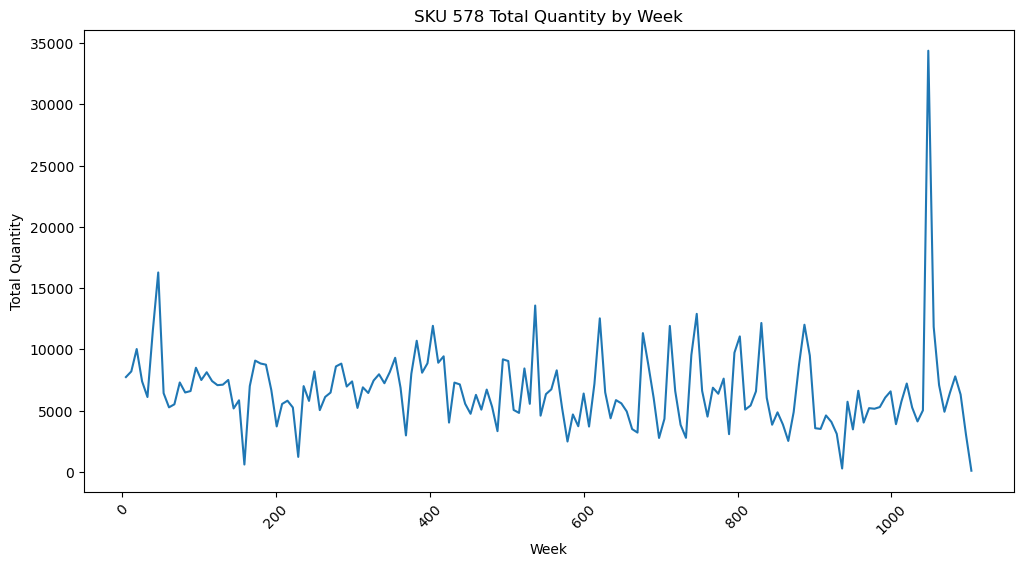

SKU 1050
Year  Week
2019  1        3291
      2        4870
      3        4834
      4        4296
      5        3518
              ...  
2021  49        717
      50       9860
      51      12875
      52       2049
      53        208
Name: TotalQuantity, Length: 158, dtype: int64


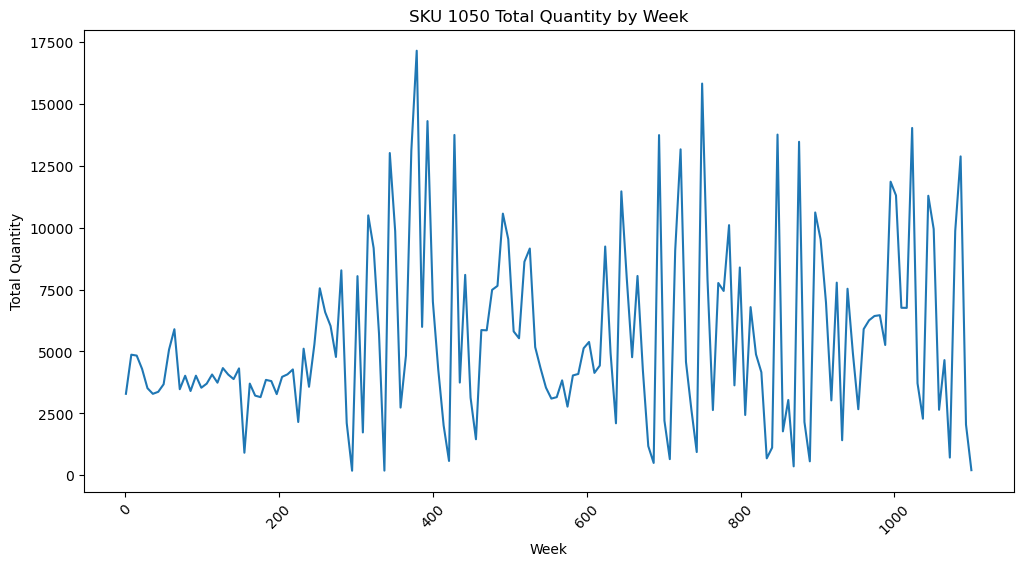

SKU 319
Year  Week
2019  1       3764
      2       3829
      3       3702
      4       3815
      5       3684
              ... 
2021  49      5788
      50      8419
      51      5845
      52      3890
      53       229
Name: TotalQuantity, Length: 158, dtype: int64


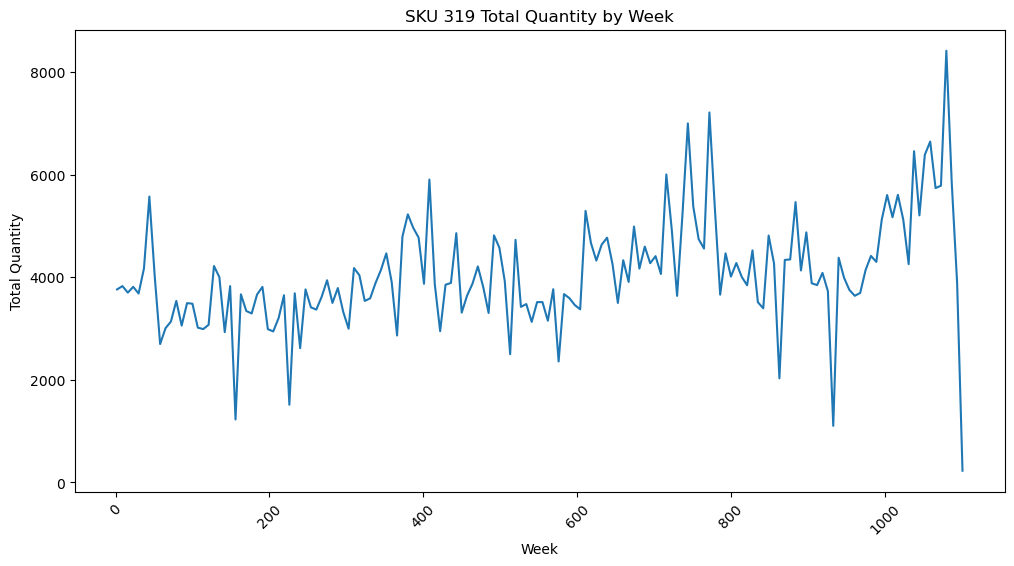

SKU 509
Year  Week
2019  1       2981
      2       3434
      3       3297
      4       2920
      5       3316
              ... 
2021  49      2494
      50      3160
      51      3468
      52      2737
      53        91
Name: TotalQuantity, Length: 158, dtype: int64


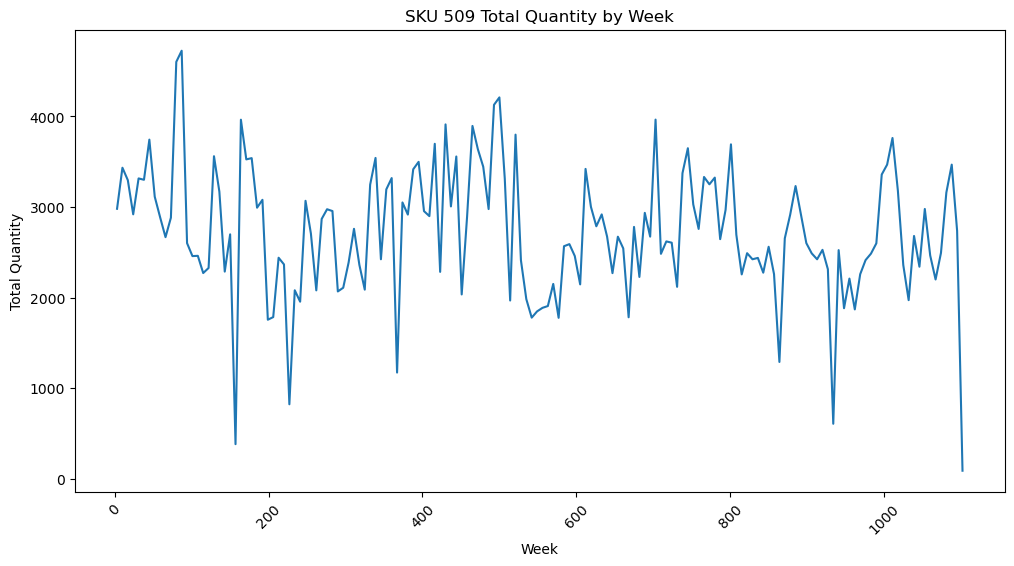

SKU 615
Year  Week
2019  1       2319
      2       2746
      3       2685
      4       3108
      5       2553
              ... 
2021  49      2885
      50      3182
      51      2877
      52      2200
      53        44
Name: TotalQuantity, Length: 158, dtype: int64


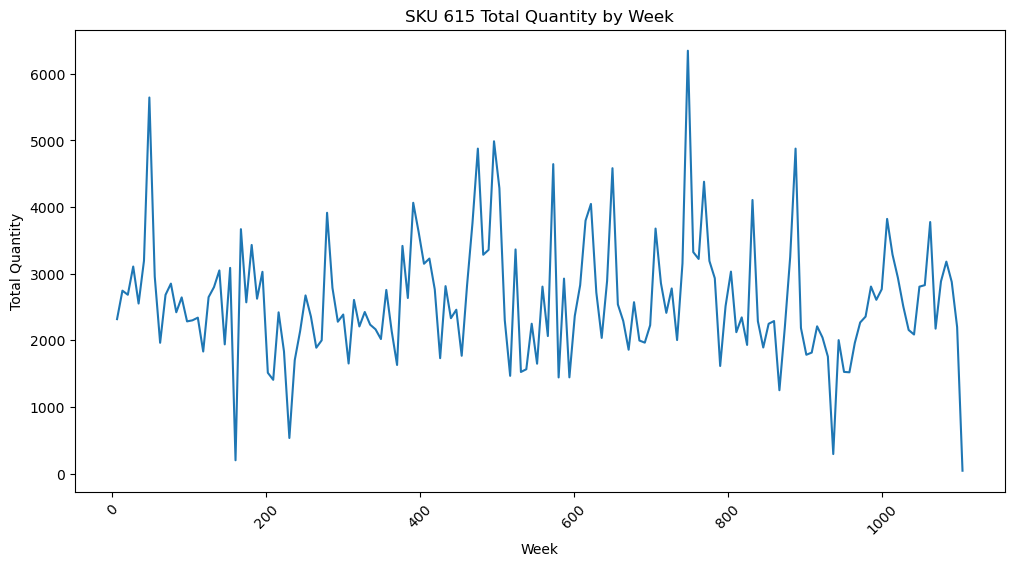

SKU 1018
Year  Week
2019  1       1064
      2       1128
      3       1166
      4        905
      5       1137
              ... 
2021  49      2015
      50      1835
      51      1259
      52      1140
      53        74
Name: TotalQuantity, Length: 158, dtype: int64


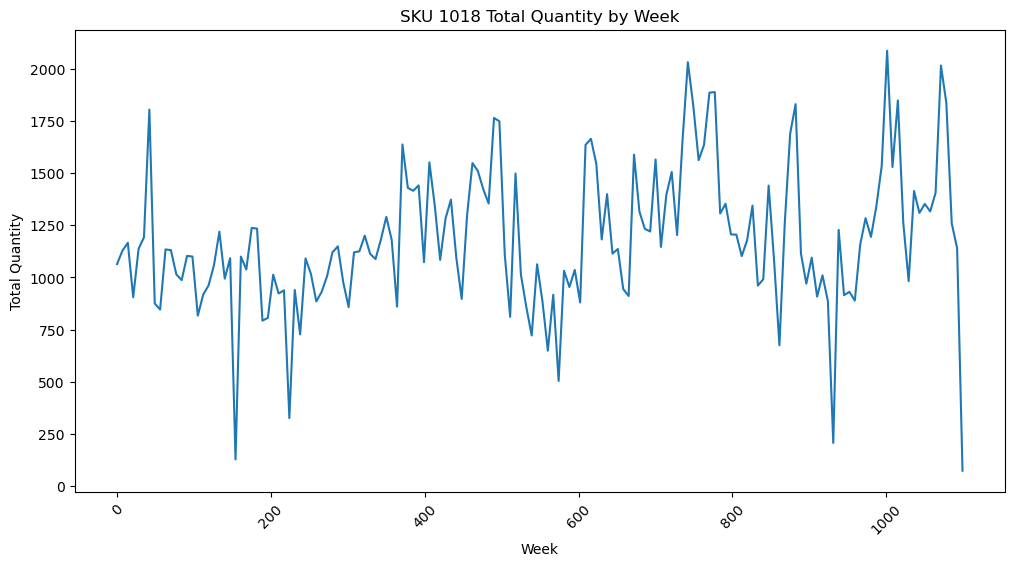

In [151]:
for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = weekly_data[weekly_data['SkuID'] == sku_id]
    sku_data.set_index(['Year', 'Week'], inplace=True)
    print(sku_data['TotalQuantity'])
    plot_sku_weekly(sku_id)

SKU 568


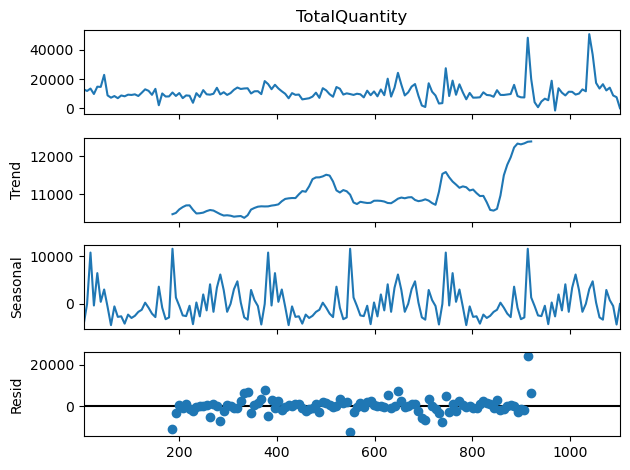

SKU 578


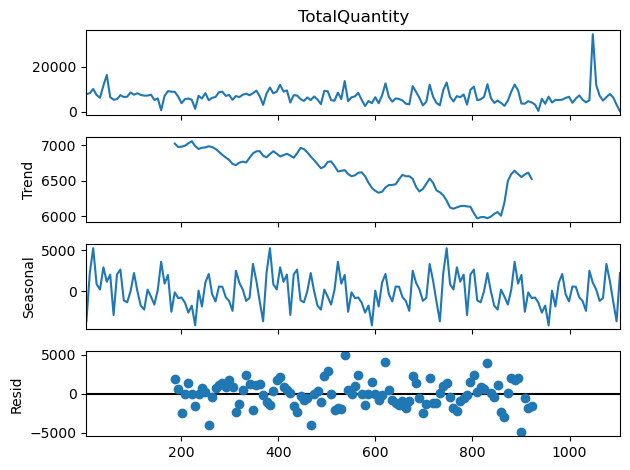

SKU 1050


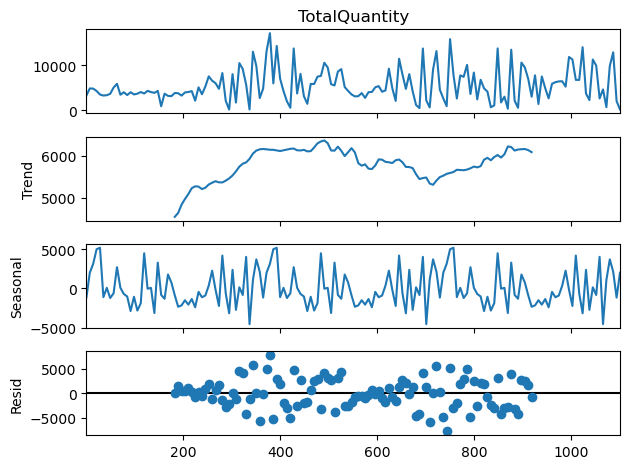

SKU 319


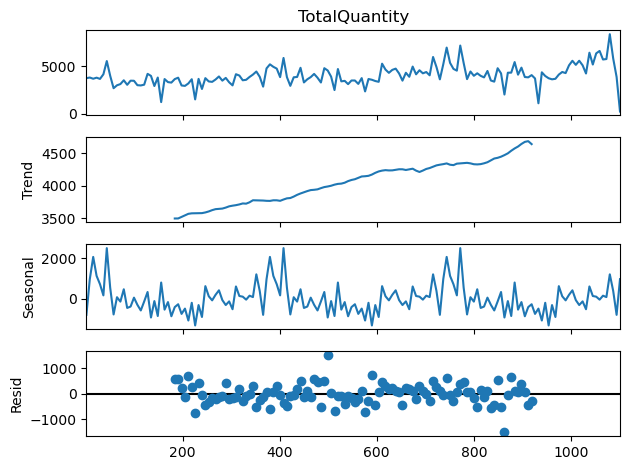

SKU 509


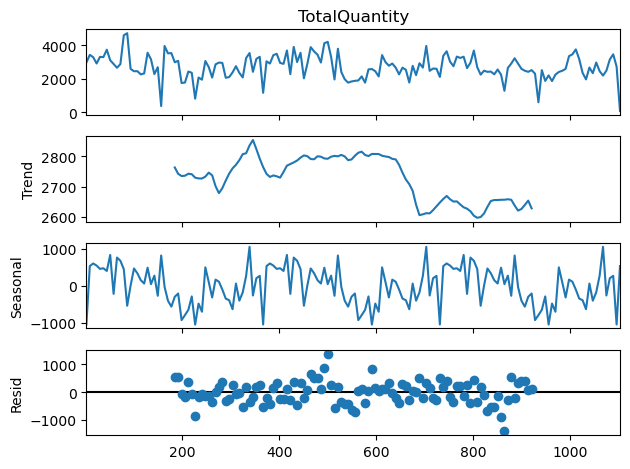

SKU 615


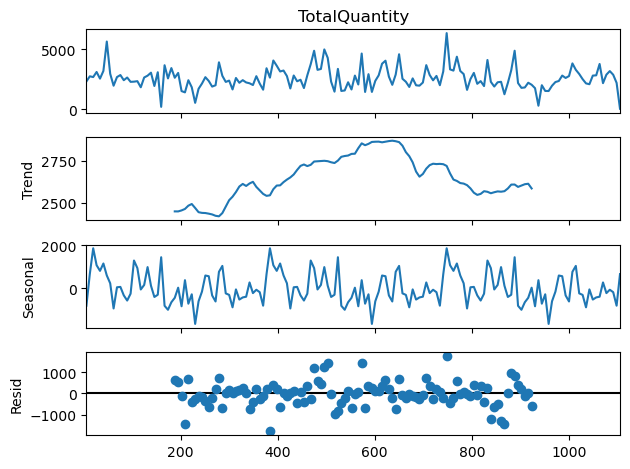

SKU 1018


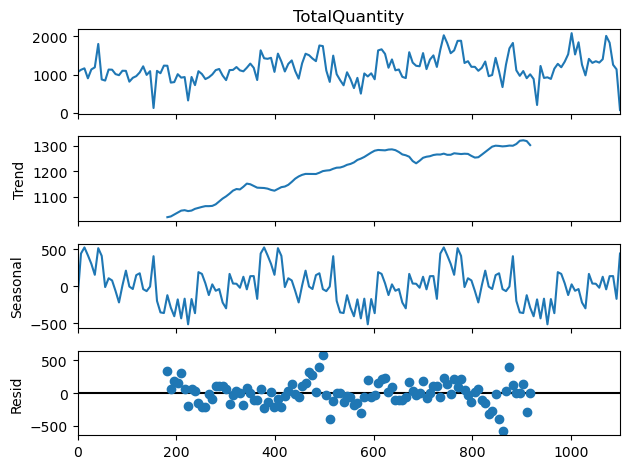

In [152]:
from statsmodels.tsa.seasonal import seasonal_decompose

for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = weekly_data[weekly_data['SkuID'] == sku_id]
    result = seasonal_decompose(sku_data['TotalQuantity'], model='additive', period=52)
    result.plot()
    plt.show()

In [153]:
weekly_data.set_index(['Year', 'Week'], inplace=True)
weekly_data

SkuID  TotalQuantity
Year Week                     
2019 1     1018           1064
     1     1050           3291
     1      319           3764
     1      509           2981
     1      568          13012
...         ...            ...
2021 53     319            229
     53     509             91
     53     568             88
     53     578             90
     53     615             44

[1106 rows x 2 columns]

## Forecasting

### Exponential Smoothing

In [154]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

exponential_smoothing_forecast_weekly = []

def forecast_sku_ExponentialSmoothing_weekly(sku_id):
    sku_data = weekly_data[weekly_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-52]
    validation = sku_data['TotalQuantity'][-52:]
    
    # Train the model
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=52, trend='add').fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(52)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 52 weeks
    full_model = ExponentialSmoothing(sku_data['TotalQuantity'], seasonal='add', seasonal_periods=52, trend='add').fit()
    future_forecast = full_model.forecast(52)
    future_forecast = future_forecast.astype(int)
    
    forecast_weeks = [(2021, i) for i in range(1, 53)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, week in forecast_weeks], 
        'Week': [week for year, week in forecast_weeks], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Week'], inplace=True)
    
    # Append results including validation metrics
    exponential_smoothing_forecast_weekly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3),
    })

In [155]:
for sku_id in all_sku_ids:
    forecast_sku_ExponentialSmoothing_weekly(sku_id)

In [156]:
exponential_smoothing_forecast_weekly = pd.DataFrame(exponential_smoothing_forecast_weekly)
exponential_smoothing_forecast_weekly.set_index('sku_id', inplace=True)
exponential_smoothing_forecast_weekly

mape           mse      rmse      bias
sku_id                                         
568     4.115  8.551615e+07  9247.494 -2011.990
578     2.334  2.614115e+07  5112.842    19.738
1050    3.113  3.747607e+07  6121.770  -393.668
319     0.708  1.656245e+06  1286.952   291.649
509     0.953  8.716853e+05   933.641   251.287
615     2.217  1.620565e+06  1273.014   497.775
1018    0.793  2.058967e+05   453.758   134.343

### Moving Average

In [157]:
moving_average_forecast_weekly = []

def forecast_sku_MovingAverage_weekly(sku_id, window=52):
    sku_data = weekly_data[weekly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-52]
    validation = sku_data['TotalQuantity'][-52:]
    
    # Calculate moving average forecast for the validation period
    validation_forecast = np.full(52, moving_average_forecast(train, window))
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast)
    
    # Calculate moving average forecast for the next 52 weeks
    future_forecast = np.full(52, moving_average_forecast(sku_data['TotalQuantity'], window)).astype(int)
    
    forecast_weeks = [(2021, i) for i in range(1, 53)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, week in forecast_weeks], 
        'Week': [week for year, week in forecast_weeks], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Week'], inplace=True)
    
    # Append results including validation metrics
    moving_average_forecast_weekly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })

In [158]:
for sku_id in all_sku_ids:
    forecast_sku_MovingAverage_weekly(sku_id)

In [159]:
moving_average_forecast_weekly = pd.DataFrame(moving_average_forecast_weekly)
moving_average_forecast_weekly.set_index('sku_id', inplace=True)
moving_average_forecast_weekly

mape           mse      rmse      bias
sku_id                                         
568     2.704  9.560878e+07  9777.974 -1723.865
578     2.231  2.278172e+07  4773.020   156.231
1050    2.052  1.701753e+07  4125.231   -83.769
319     0.547  2.101013e+06  1449.487  -487.942
509     0.816  4.966522e+05   704.736   208.346
615     1.644  1.088138e+06  1043.138   234.346
1018    0.587  1.689774e+05   411.069   -58.250

### Naive

In [160]:
naive_forecast_weekly = []

def forecast_sku_Naive_weekly(sku_id):
    sku_data = weekly_data[weekly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-52]
    validation = sku_data['TotalQuantity'][-52:]
    
    # Use the last observed value in the training set to forecast the validation period
    last_observed_value = train.iloc[-1]
    validation_forecast = np.full(52, last_observed_value)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast)
    
    # Use the last observed value in the entire dataset to forecast the next 52 weeks
    last_observed_value_full = sku_data['TotalQuantity'].iloc[-1]
    future_forecast = np.full(52, last_observed_value_full).astype(int)
    
    forecast_weeks = [(2021, i) for i in range(1, 53)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, week in forecast_weeks], 
        'Week': [week for year, week in forecast_weeks], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Week'], inplace=True)
    naive_forecast_weekly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })
    


In [161]:
for sku_id in all_sku_ids:
    forecast_sku_Naive_weekly(sku_id)
    

In [162]:
naive_forecast_weekly = pd.DataFrame(naive_forecast_weekly)
naive_forecast_weekly.set_index('sku_id', inplace=True)
naive_forecast_weekly

mape           mse       rmse      bias
sku_id                                          
568     1.370  1.695203e+08  13019.996 -8768.308
578     3.497  3.238246e+07   5690.559  3102.442
1050    1.049  2.860755e+07   5348.603 -3405.442
319     0.729  2.271959e+06   1507.302   639.558
509     1.088  1.058169e+06   1028.673   777.769
615     1.920  1.395670e+06   1181.385   602.038
1018    0.904  3.000052e+05    547.727   366.635

## Seasonal Forecasting Methods

There are seasonal patterns in the weekly data. So, we can use forecasting methods that can capture the seasonality.

- Triple Exponential Smoothing
- ARIMA
- SARIMA

### Triple Exponential Smoothing

In [163]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

triple_exponential_smoothing_forecast_weekly = []

def forecast_sku_TripleExponentialSmoothing_weekly(sku_id):
    sku_data = weekly_data[weekly_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-52]
    validation = sku_data['TotalQuantity'][-52:]
    
    # Train the model
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=52, trend='add').fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(52)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 52 weeks
    full_model = ExponentialSmoothing(sku_data['TotalQuantity'], seasonal='add', seasonal_periods=52, trend='add').fit()
    future_forecast = full_model.forecast(52)
    future_forecast = future_forecast.astype(int)
    
    forecast_weeks = [(2021, i) for i in range(1, 53)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, week in forecast_weeks], 
        'Week': [week for year, week in forecast_weeks], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Week'], inplace=True)
    
    # Append results including validation metrics
    triple_exponential_smoothing_forecast_weekly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3),
    })

In [164]:
for sku_id in all_sku_ids:
    forecast_sku_TripleExponentialSmoothing_weekly(sku_id)
    

In [165]:
triple_exponential_smoothing_forecast_weekly = pd.DataFrame(triple_exponential_smoothing_forecast_weekly)
triple_exponential_smoothing_forecast_weekly.set_index('sku_id', inplace=True)
triple_exponential_smoothing_forecast_weekly

mape           mse      rmse      bias
sku_id                                         
568     4.115  8.551615e+07  9247.494 -2011.990
578     2.334  2.614115e+07  5112.842    19.738
1050    3.113  3.747607e+07  6121.770  -393.668
319     0.708  1.656245e+06  1286.952   291.649
509     0.953  8.716853e+05   933.641   251.287
615     2.217  1.620565e+06  1273.014   497.775
1018    0.793  2.058967e+05   453.758   134.343

### ARIMA

In [166]:
from statsmodels.tsa.arima.model import ARIMA

arima_forecast_weekly = []

def forecast_sku_ARIMA_weekly(sku_id):
    sku_data = weekly_data[weekly_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-52]
    validation = sku_data['TotalQuantity'][-52:]
    
    # Train the model
    model = ARIMA(train, order=(5,1,0)).fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(steps=52)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 52 weeks
    full_model = ARIMA(sku_data['TotalQuantity'], order=(5,1,0)).fit()
    future_forecast = full_model.forecast(steps=52)
    future_forecast = future_forecast.astype(int)
    
    forecast_weeks = [(2021, i) for i in range(1, 53)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, week in forecast_weeks], 
        'Week': [week for year, week in forecast_weeks], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Week'], inplace=True)
    
    # Append results including validation metrics
    arima_forecast_weekly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })

In [167]:
for sku_id in all_sku_ids:
    forecast_sku_ARIMA_weekly(sku_id)
    

In [168]:
arima_forecast_weekly = pd.DataFrame(arima_forecast_weekly)
arima_forecast_weekly.set_index('sku_id', inplace=True)
arima_forecast_weekly


mape           mse       rmse      bias
sku_id                                          
568     1.826  1.242793e+08  11148.063 -5683.431
578     2.224  2.236072e+07   4728.712   159.588
1050    2.239  1.687103e+07   4107.436   436.870
319     0.642  1.887227e+06   1373.764   217.996
509     0.824  5.015608e+05    708.210   229.187
615     1.583  1.053827e+06   1026.561   141.673
1018    0.734  1.952780e+05    441.903   169.077

### SARIMA

In [169]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_forecast_weekly = []

def forecast_sku_SARIMA_weekly(sku_id):
    sku_data = weekly_data[weekly_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-52]
    validation = sku_data['TotalQuantity'][-52:]
    
    # Train the model
    model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,52)).fit()
    
    # Forecast for the validation period
    validation_forecast = model.get_forecast(steps=52).predicted_mean
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 52 weeks
    full_model = SARIMAX(sku_data['TotalQuantity'], order=(1,1,1), seasonal_order=(1,1,1,52)).fit()
    future_forecast = full_model.get_forecast(steps=52).predicted_mean
    future_forecast = future_forecast.astype(int)
    
    forecast_weeks = [(2021, i) for i in range(1, 53)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, week in forecast_weeks], 
        'Week': [week for year, week in forecast_weeks], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Week'], inplace=True)
    
    # Append results including validation metrics
    sarima_forecast_weekly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })

In [170]:
for sku_id in all_sku_ids:
    forecast_sku_SARIMA_weekly(sku_id)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.01980D+00    |proj g|=  1.33773D-01


 This problem is unconstrained.



At iterate    5    f=  4.97229D+00    |proj g|=  5.58126D-03

At iterate   10    f=  4.97009D+00    |proj g|=  4.29695D-04

At iterate   15    f=  4.97009D+00    |proj g|=  2.99638D-04

At iterate   20    f=  4.96993D+00    |proj g|=  5.29868D-03

At iterate   25    f=  4.95511D+00    |proj g|=  2.04532D-02

At iterate   30    f=  4.95178D+00    |proj g|=  4.63289D-04

At iterate   35    f=  4.95177D+00    |proj g|=  3.00293D-04

At iterate   40    f=  4.95175D+00    |proj g|=  2.38908D-04

At iterate   45    f=  4.95175D+00    |proj g|=  2.92872D-04

At iterate   50    f=  4.95175D+00    |proj g|=  7.35141D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92708D+00    |proj g|=  1.24934D-01

At iterate    5    f=  6.87968D+00    |proj g|=  3.49178D-02

At iterate   10    f=  6.87493D+00    |proj g|=  3.54916D-03

At iterate   15    f=  6.87462D+00    |proj g|=  6.57764D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   2.122D-05   6.875D+00
  F =   6.8746200021770409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  4.69957D+00    |proj g|=  1.13099D-02

At iterate   10    f=  4.69817D+00    |proj g|=  3.20922D-04

At iterate   15    f=  4.69817D+00    |proj g|=  1.81359D-04

At iterate   20    f=  4.69813D+00    |proj g|=  3.11034D-03

At iterate   25    f=  4.69288D+00    |proj g|=  3.93049D-02

At iterate   30    f=  4.66742D+00    |proj g|=  1.08288D-02

At iterate   35    f=  4.66024D+00    |proj g|=  5.87161D-03

At iterate   40    f=  4.65936D+00    |proj g|=  4.25164D-03

At iterate   45    f=  4.65914D+00    |proj g|=  1.17278D-03

At iterate   50    f=  4.65908D+00    |proj g|=  7.56896D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.54231D+00    |proj g|=  1.32025D-01

At iterate    5    f=  6.49855D+00    |proj g|=  2.27140D-02

At iterate   10    f=  6.49367D+00    |proj g|=  6.89340D-04

At iterate   15    f=  6.49365D+00    |proj g|=  4.18466D-05

At iterate   20    f=  6.49361D+00    |proj g|=  1.07823D-03

At iterate   25    f=  6.47219D+00    |proj g|=  1.66705D-02

At iterate   30    f=  6.47111D+00    |proj g|=  2.53327D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.97676D+00    |proj g|=  1.22143D-01

At iterate    5    f=  4.91459D+00    |proj g|=  8.40571D-03

At iterate   10    f=  4.91099D+00    |proj g|=  1.24426D-03

At iterate   15    f=  4.91092D+00    |proj g|=  3.76367D-05

At iterate   20    f=  4.91090D+00    |proj g|=  1.69770D-03

At iterate   25    f=  4.90922D+00    |proj g|=  4.71571D-03

At iterate   30    f=  4.87213D+00    |proj g|=  1.92460D-03

At iterate   35    f=  4.87138D+00    |proj g|=  9.69646D-04

At iterate   40    f=  4.87123D+00    |proj g|=  4.90774D-04

At iterate   45    f=  4.87120D+00    |proj g|=  3.61904D-04

At iterate   50    f=  4.87119D+00    |proj g|=  1.00026D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.57861D+00    |proj g|=  8.03579D-03

At iterate   10    f=  6.57633D+00    |proj g|=  2.03310D-04

At iterate   15    f=  6.57633D+00    |proj g|=  6.85188D-05

At iterate   20    f=  6.57630D+00    |proj g|=  2.11614D-03

At iterate   25    f=  6.55328D+00    |proj g|=  3.39276D-02

At iterate   30    f=  6.54055D+00    |proj g|=  4.56210D-03

At iterate   35    f=  6.54028D+00    |proj g|=  2.06588D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     41      1     0     0   1.066D-05   6.540D+00
  F =   6.5402782374976525     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04457D+00    |proj g|=  9.77367D-02

At iterate    5    f=  4.01611D+00    |proj g|=  1.75263D-02

At iterate   10    f=  4.01370D+00    |proj g|=  5.94802D-04

At iterate   15    f=  4.01368D+00    |proj g|=  7.64297D-04

At iterate   20    f=  3.99960D+00    |proj g|=  4.59963D-02

At iterate   25    f=  3.98603D+00    |proj g|=  1.20846D-02

At iterate   30    f=  3.98369D+00    |proj g|=  1.03153D-02

At iterate   35    f=  3.98292D+00    |proj g|=  4.39816D-03

At iterate   40    f=  3.98265D+00    |proj g|=  2.81908D-03

At iterate   45    f=  3.98255D+00    |proj g|=  1.13683D-03

At iterate   50    f=  3.98249D+00    |proj g|=  1.95764D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.57213D+00    |proj g|=  2.73002D-02

At iterate   10    f=  5.56441D+00    |proj g|=  3.23765D-03

At iterate   15    f=  5.56395D+00    |proj g|=  2.51782D-04

At iterate   20    f=  5.56394D+00    |proj g|=  8.12238D-04

At iterate   25    f=  5.56191D+00    |proj g|=  1.93437D-02

At iterate   30    f=  5.55555D+00    |proj g|=  1.14264D-02

At iterate   35    f=  5.55503D+00    |proj g|=  1.07086D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     41      1     0     0   1.487D-06   5.555D+00
  F =   5.5550308890108502     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  4.13068D+00    |proj g|=  1.65377D-02

At iterate   10    f=  4.12252D+00    |proj g|=  1.02370D-02

At iterate   15    f=  4.12107D+00    |proj g|=  2.32217D-04

At iterate   20    f=  4.12105D+00    |proj g|=  1.00584D-03

At iterate   25    f=  4.11624D+00    |proj g|=  3.97754D-02

At iterate   30    f=  4.00694D+00    |proj g|=  4.04421D-02

At iterate   35    f=  3.99045D+00    |proj g|=  2.81575D-03

At iterate   40    f=  3.98791D+00    |proj g|=  7.62044D-03

At iterate   45    f=  3.98683D+00    |proj g|=  1.48870D-03

At iterate   50    f=  3.98647D+00    |proj g|=  7.28468D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.55405D+00    |proj g|=  2.66713D-01

At iterate    5    f=  5.46623D+00    |proj g|=  1.56263D-02

At iterate   10    f=  5.45502D+00    |proj g|=  3.59250D-03

At iterate   15    f=  5.45470D+00    |proj g|=  1.19781D-03

At iterate   20    f=  5.42085D+00    |proj g|=  9.96768D-02

At iterate   25    f=  5.39896D+00    |proj g|=  5.60830D-03

At iterate   30    f=  5.39798D+00    |proj g|=  1.36402D-03

At iterate   35    f=  5.39788D+00    |proj g|=  9.35863D-04

At iterate   40    f=  5.39785D+00    |proj g|=  8.99081D-04

At iterate   45    f=  5.39785D+00    |proj g|=  2.69085D-04

At iterate   50    f=  5.39784D+00    |proj g|=  7.54562D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  4.22040D+00    |proj g|=  9.44223D-03

At iterate   10    f=  4.21168D+00    |proj g|=  4.41290D-03

At iterate   15    f=  4.21009D+00    |proj g|=  9.62675D-04

At iterate   20    f=  4.21006D+00    |proj g|=  6.42414D-04

At iterate   25    f=  4.17893D+00    |proj g|=  1.14739D-01

At iterate   30    f=  4.13969D+00    |proj g|=  3.33465D-03

At iterate   35    f=  4.13670D+00    |proj g|=  6.77261D-03

At iterate   40    f=  4.13549D+00    |proj g|=  4.48349D-03

At iterate   45    f=  4.13504D+00    |proj g|=  3.57225D-03

At iterate   50    f=  4.13483D+00    |proj g|=  7.27436D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.72613D+00    |proj g|=  2.33218D-01

At iterate    5    f=  5.64547D+00    |proj g|=  1.48487D-02

At iterate   10    f=  5.63426D+00    |proj g|=  4.79536D-04

At iterate   15    f=  5.63419D+00    |proj g|=  8.11723D-04

At iterate   20    f=  5.60806D+00    |proj g|=  3.12273D-02

At iterate   25    f=  5.58765D+00    |proj g|=  1.20087D-02

At iterate   30    f=  5.58561D+00    |proj g|=  2.24994D-03

At iterate   35    f=  5.58538D+00    |proj g|=  4.00434D-04

At iterate   40    f=  5.58534D+00    |proj g|=  7.73399D-04

At iterate   45    f=  5.58533D+00    |proj g|=  1.51255D-04

At iterate   50    f=  5.58533D+00    |proj g|=  1.65728D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.63256D+00    |proj g|=  1.67109D-02

At iterate   10    f=  3.61759D+00    |proj g|=  1.10373D-02

At iterate   15    f=  3.61704D+00    |proj g|=  1.69528D-03

At iterate   20    f=  3.61678D+00    |proj g|=  2.62684D-03

At iterate   25    f=  3.60825D+00    |proj g|=  3.57874D-02

At iterate   30    f=  3.59213D+00    |proj g|=  1.09187D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     41      1     0     0   8.216D-06   3.592D+00
  F =   3.5917996764426725     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  4.91468D+00    |proj g|=  2.10282D-02

At iterate   10    f=  4.91079D+00    |proj g|=  3.68445D-03

At iterate   15    f=  4.91067D+00    |proj g|=  1.29877D-03

At iterate   20    f=  4.91010D+00    |proj g|=  2.71126D-02

At iterate   25    f=  4.89681D+00    |proj g|=  2.43783D-03

At iterate   30    f=  4.89613D+00    |proj g|=  5.09909D-04

At iterate   35    f=  4.89605D+00    |proj g|=  6.30843D-04

At iterate   40    f=  4.89603D+00    |proj g|=  3.15508D-04

At iterate   45    f=  4.89602D+00    |proj g|=  8.41793D-05

At iterate   50    f=  4.89602D+00    |proj g|=  2.82130D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [171]:
sarima_forecast_weekly = pd.DataFrame(sarima_forecast_weekly)
sarima_forecast_weekly.set_index('sku_id', inplace=True)
sarima_forecast_weekly

mape           mse       rmse      bias
sku_id                                          
568     3.245  1.032325e+08  10160.339 -3967.869
578     2.814  2.841218e+07   5330.308   766.207
1050    3.664  2.814433e+07   5305.123  2162.792
319     0.693  1.710114e+06   1307.713    79.867
509     0.867  9.663768e+05    983.045  -126.374
615     2.023  1.579136e+06   1256.637   244.455
1018    0.808  2.174435e+05    466.308   123.653

# Weekly: Comparison of Forecasting Methods
## Bias Values of Forecasting Methods


In [172]:
all_forecasts_bias_weekly = pd.concat([exponential_smoothing_forecast_weekly['bias'], moving_average_forecast_weekly['bias'], naive_forecast_weekly['bias'], triple_exponential_smoothing_forecast_weekly['bias'], arima_forecast_weekly['bias'], sarima_forecast_weekly['bias']], axis=1)

all_forecasts_bias_weekly.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']

all_forecasts_bias_weekly


Exponential Smoothing  Moving Average     Naive  \
sku_id                                                    
568                 -2011.990       -1723.865 -8768.308   
578                    19.738         156.231  3102.442   
1050                 -393.668         -83.769 -3405.442   
319                   291.649        -487.942   639.558   
509                   251.287         208.346   777.769   
615                   497.775         234.346   602.038   
1018                  134.343         -58.250   366.635   

        Triple Exponential Smoothing     ARIMA    SARIMA  
sku_id                                                    
568                        -2011.990 -5683.431 -3967.869  
578                           19.738   159.588   766.207  
1050                        -393.668   436.870  2162.792  
319                          291.649   217.996    79.867  
509                          251.287   229.187  -126.374  
615                          497.775   141.673   244.455  
1018                         134.343   169.077   123.653

<Figure size 1200x600 with 0 Axes>

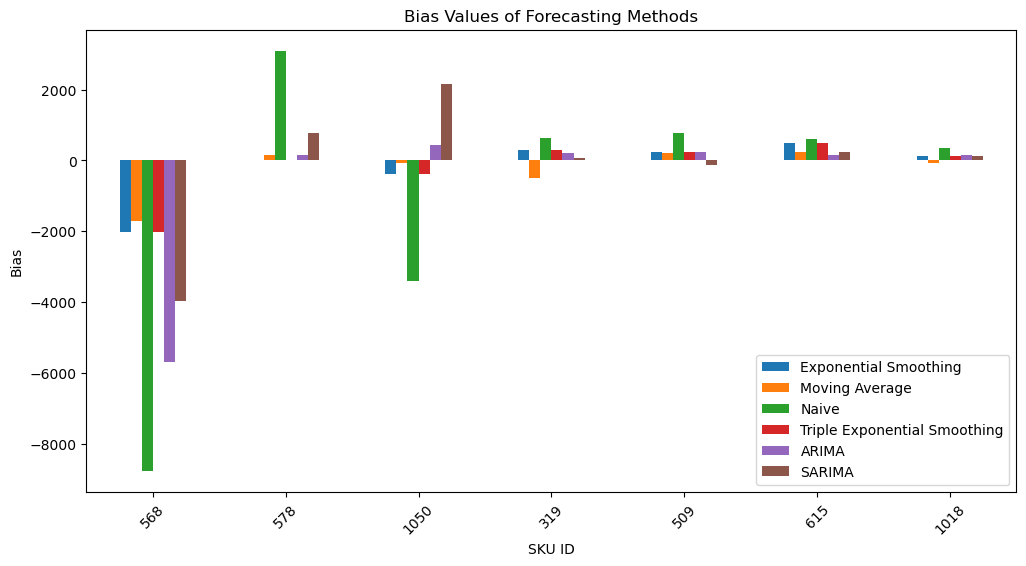

In [173]:
plt.figure(figsize=(12, 6))
all_forecasts_bias_weekly.plot(kind='bar', figsize=(12, 6))
plt.title('Bias Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('Bias')
plt.xticks(rotation=45)
plt.show()


## MAPE Values of Forecasting Methods

In [174]:
all_forecasts_mape_weekly = pd.concat([exponential_smoothing_forecast_weekly['mape'], moving_average_forecast_weekly['mape'], naive_forecast_weekly['mape'], triple_exponential_smoothing_forecast_weekly['mape'], arima_forecast_weekly['mape'], sarima_forecast_weekly['mape']], axis=1)

all_forecasts_mape_weekly.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']

all_forecasts_mape_weekly

Exponential Smoothing  Moving Average  Naive  \
sku_id                                                 
568                     4.115           2.704  1.370   
578                     2.334           2.231  3.497   
1050                    3.113           2.052  1.049   
319                     0.708           0.547  0.729   
509                     0.953           0.816  1.088   
615                     2.217           1.644  1.920   
1018                    0.793           0.587  0.904   

        Triple Exponential Smoothing  ARIMA  SARIMA  
sku_id                                               
568                            4.115  1.826   3.245  
578                            2.334  2.224   2.814  
1050                           3.113  2.239   3.664  
319                            0.708  0.642   0.693  
509                            0.953  0.824   0.867  
615                            2.217  1.583   2.023  
1018                           0.793  0.734   0.808

<Figure size 1200x600 with 0 Axes>

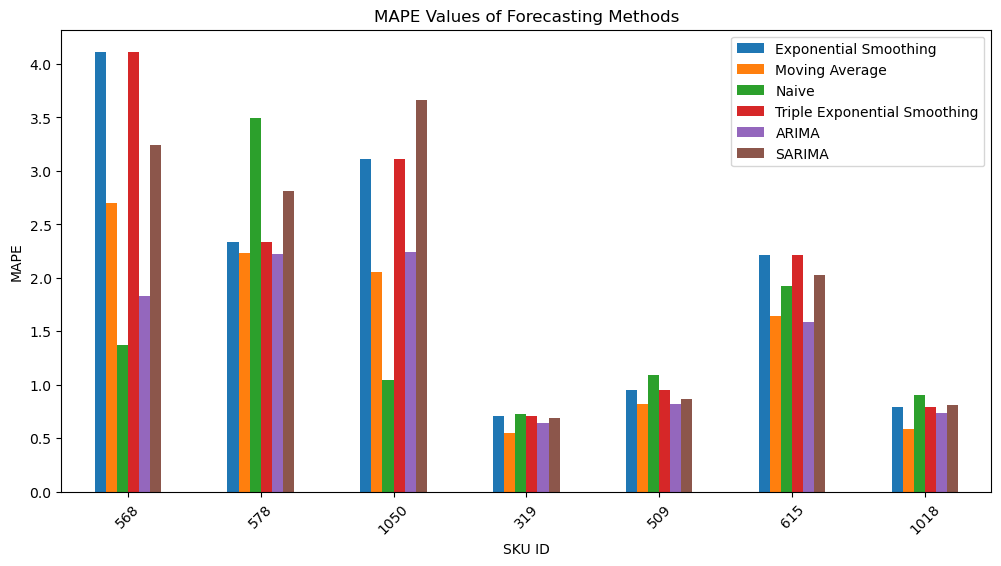

In [175]:
plt.figure(figsize=(12, 6))
all_forecasts_mape_weekly.plot(kind='bar', figsize=(12, 6))
plt.title('MAPE Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('MAPE')
plt.xticks(rotation=45)
plt.show()

## MAD = |Actual - Forecasted| / n

MAD is the average of the absolute differences between the forecasted values and the actual values. It is a measure of the accuracy of the forecasting method. The lower the MAD value, the more accurate the forecasting method is.

In [177]:
exponential_smoothing_forecast_weekly

mape           mse      rmse      bias
sku_id                                         
568     4.115  8.551615e+07  9247.494 -2011.990
578     2.334  2.614115e+07  5112.842    19.738
1050    3.113  3.747607e+07  6121.770  -393.668
319     0.708  1.656245e+06  1286.952   291.649
509     0.953  8.716853e+05   933.641   251.287
615     2.217  1.620565e+06  1273.014   497.775
1018    0.793  2.058967e+05   453.758   134.343

In [176]:
all_forecasts_mad_weekly = pd.concat([exponential_smoothing_forecast_weekly['mad'], moving_average_forecast_weekly['mad'], naive_forecast_weekly['mad'], triple_exponential_smoothing_forecast_weekly['mad'], arima_forecast_weekly['mad'], sarima_forecast_weekly['mad']], axis=1)

all_forecasts_mad_weekly.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']

all_forecasts_mad_weekly

KeyError: 'mad'

In [ ]:
plt.figure(figsize=(12, 6))
all_forecasts_mad_weekly.plot(kind='bar', figsize=(12, 6))
plt.title('MAD Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('MAD')
plt.xticks(rotation=45)
plt.show()

## All Metrics Comparison

In [ ]:
all_forecasts_metrics_weekly = pd.concat([exponential_smoothing_forecast_weekly, moving_average_forecast_weekly, naive_forecast_weekly, triple_exponential_smoothing_forecast_weekly, arima_forecast_weekly, sarima_forecast_weekly], axis=1)
all_forecasts_metrics_weekly.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']
all_forecasts_metrics_weekly

In [ ]:
plt.figure(figsize=(12, 6))
all_forecasts_metrics_weekly.plot(kind='bar', figsize=(12, 6))
plt.title('Weekly Forecasting Methods Comparison')
plt.xlabel('SKU ID')
plt.ylabel('Metrics')
plt.xticks(rotation=45)
plt.show()

# Daily Sales Analysis and Forecasting

In this section, we will analyze the daily sales data and forecast the sales for the next 360 days.

In [ ]:
daily_data = data.copy()
daily_data['Date'] = pd.to_datetime(daily_data['Date'])
daily_data = daily_data.groupby(['Date', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()

daily_data

In [ ]:
daily_skus = all_sku_ids
# ['319']

In [ ]:
def plot_sku_daily(sku_id):
    sku = daily_data[daily_data['SkuID'] == sku_id]
    plt.figure(figsize=(12, 6))
    plt.plot(sku['Date'], sku['TotalQuantity'])
    plt.title(f'SKU {sku_id} Total Quantity by Day')
    plt.xlabel('Day')
    plt.ylabel('Total Quantity')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
for sku_id in daily_skus:
    print(f'SKU {sku_id}')
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    sku_data.set_index(['Date'], inplace=True)
    plot_sku_daily(sku_id)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

for sku_id in daily_skus:
    print(f'SKU {sku_id}')
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    result = seasonal_decompose(sku_data['TotalQuantity'], model='additive', period=360)
    result.plot()
    plt.show()
    

In [ ]:
daily_data.set_index(['Date'], inplace=True)
daily_data

## Exponential Smoothing

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

exponential_smoothing_forecast_daily = []

def forecast_sku_ExponentialSmoothing_daily(sku_id):
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-360]
    validation = sku_data['TotalQuantity'][-360:]
    
    # Train the model
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=90, trend='add').fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(360)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 360 days
    full_model = ExponentialSmoothing(sku_data['TotalQuantity'], seasonal='add', seasonal_periods=360, trend='add').fit()
    future_forecast = full_model.forecast(360)
    future_forecast = future_forecast.astype(int)
    
    forecast_dates = pd.date_range(start=sku_data.index[-1], periods=360, freq='D')
    forecast_table = pd.DataFrame({
        'Date': forecast_dates, 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Date'], inplace=True)
    
    # Append results including validation metrics
    exponential_smoothing_forecast_daily.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
'mad': round(mad, 3)
    })
    

In [ ]:
for sku_id in daily_skus:
    forecast_sku_ExponentialSmoothing_daily(sku_id)

In [ ]:
exponential_smoothing_forecast_daily = pd.DataFrame(exponential_smoothing_forecast_daily)
exponential_smoothing_forecast_daily.set_index('sku_id', inplace=True)
exponential_smoothing_forecast_daily

## Moving Average

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def moving_average_forecast(series, window):
    return series.rolling(window=window).mean().iloc[-1]

def evaluate_model(series, window):
    forecast = moving_average_forecast(series, window)
    mse = mean_squared_error(series[-360:], np.full(360, forecast))
    return mse

def find_best_window_size(series, window_range):
    best_window = None
    best_mse = float('inf')
    for window in window_range:
        mse = evaluate_model(series, window)
        if mse < best_mse:
            best_mse = mse
            best_window = window
    return best_window

window_range = range(1, 365)  

best_window = find_best_window_size(daily_data['TotalQuantity'], window_range)
print('Best Window Size:', best_window)

In [ ]:
moving_average_forecast_daily = []

def moving_average_forecast(series, window):
    return series.rolling(window=window).mean().iloc[-1]

def forecast_sku_MovingAverage_daily(sku_id, window=360):
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-360]
    validation = sku_data['TotalQuantity'][-360:]
    
    # Calculate moving average forecast for the validation period
    validation_forecast = np.full(360, moving_average_forecast(train, window))
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast)
    
    # Calculate moving average forecast for the next 360 days
    future_forecast = np.full(360, moving_average_forecast(sku_data['TotalQuantity'], window)).astype(int)
    
    forecast_dates = pd.date_range(start=sku_data.index[-1], periods=360, freq='D')
    forecast_table = pd.DataFrame({
        'Date': forecast_dates, 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Date'], inplace=True)
    
    # Append results including validation metrics
    moving_average_forecast_daily.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })

In [ ]:
for sku_id in daily_skus:
    forecast_sku_MovingAverage_daily(sku_id)

In [ ]:
moving_average_forecast_daily = pd.DataFrame(moving_average_forecast_daily)
moving_average_forecast_daily.set_index('sku_id', inplace=True)
moving_average_forecast_daily

## Naive

In [ ]:
naive_forecast_daily = []

def forecast_sku_Naive_daily(sku_id):
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-360]
    validation = sku_data['TotalQuantity'][-360:]
    
    # Use the last observed value in the training set to forecast the validation period
    last_observed_value = train.iloc[-1]
    validation_forecast = np.full(360, last_observed_value)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast)
    
    # Use the last observed value in the entire dataset to forecast the next 360 days
    last_observed_value_full = sku_data['TotalQuantity'].iloc[-1]
    future_forecast = np.full(360, last_observed_value_full).astype(int)
    
    forecast_dates = pd.date_range(start=sku_data.index[-1], periods=360, freq='D')
    forecast_table = pd.DataFrame({
        'Date': forecast_dates, 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Date'], inplace=True)
    naive_forecast_daily.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })

In [ ]:
for sku_id in daily_skus:
    forecast_sku_Naive_daily(sku_id)
    

In [ ]:
naive_forecast_daily = pd.DataFrame(naive_forecast_daily)
naive_forecast_daily.set_index('sku_id', inplace=True)
naive_forecast_daily


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

triple_exponential_smoothing_forecast_daily = []

def forecast_sku_TripleExponentialSmoothing_daily(sku_id):
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-360]
    validation = sku_data['TotalQuantity'][-360:]
    
    # Train the model
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=90, trend='add').fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(360)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 360 days
    
    full_model = ExponentialSmoothing(sku_data['TotalQuantity'], seasonal='add', seasonal_periods=90, trend='add').fit()
    future_forecast = full_model.forecast(360)
    future_forecast = future_forecast.astype(int)
    
    forecast_dates = pd.date_range(start=sku_data.index[-1], periods=360, freq='D')
    forecast_table = pd.DataFrame({
        'Date': forecast_dates, 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Date'], inplace=True)
    
    # Append results including validation metrics
    triple_exponential_smoothing_forecast_daily.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })

In [ ]:
for sku_id in daily_skus:
    forecast_sku_TripleExponentialSmoothing_daily(sku_id)
    

In [ ]:
triple_exponential_smoothing_forecast_daily = pd.DataFrame(triple_exponential_smoothing_forecast_daily)
triple_exponential_smoothing_forecast_daily.set_index('sku_id', inplace=True)
triple_exponential_smoothing_forecast_daily


# Daily: Seasonal Forecasting Methods

There are seasonal patterns in the weekly data. So, we can use forecasting methods that can capture the seasonality.

- Triple Exponential Smoothing
- ARIMA
- SARIMA

## Triple Exponential Smoothing

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

triple_exponential_smoothing_forecast_daily = []

def forecast_sku_TripleExponentialSmoothing_daily(sku_id):
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-360]
    validation = sku_data['TotalQuantity'][-360:]
    
    # Train the model
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=90, trend='add').fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(360)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 360 days
    full_model = ExponentialSmoothing(sku_data['TotalQuantity'], seasonal='add', seasonal_periods=90, trend='add').fit()
    future_forecast = full_model.forecast(360)
    future_forecast = future_forecast.astype(int)
    
    forecast_dates = pd.date_range(start=sku_data.index[-1], periods=360, freq='D')
    forecast_table = pd.DataFrame({
        'Date': forecast_dates, 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Date'], inplace=True)
    
    # Append results including validation metrics
    triple_exponential_smoothing_forecast_daily.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })

In [ ]:
for sku_id in daily_skus:
    forecast_sku_TripleExponentialSmoothing_daily(sku_id)
    

In [ ]:
triple_exponential_smoothing_forecast_daily = pd.DataFrame(triple_exponential_smoothing_forecast_daily)
triple_exponential_smoothing_forecast_daily.set_index('sku_id', inplace=True)
triple_exponential_smoothing_forecast_daily

## ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_forecast_daily = []

def forecast_sku_ARIMA_daily(sku_id):
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-360]
    validation = sku_data['TotalQuantity'][-360:]
    
    # Train the model
    model = ARIMA(train, order=(5,1,0)).fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(steps=360)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 360 days
    full_model = ARIMA(sku_data['TotalQuantity'], order=(5,1,0)).fit()
    future_forecast = full_model.forecast(steps=360)
    future_forecast = future_forecast.astype(int)
    
    forecast_dates = pd.date_range(start=sku_data.index[-1], periods=360, freq='D')
    forecast_table = pd.DataFrame({
        'Date': forecast_dates, 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Date'], inplace=True)
    
    # Append results including validation metrics
    arima_forecast_daily.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })
    
    

In [ ]:
for sku_id in daily_skus:
    forecast_sku_ARIMA_daily(sku_id)
    

In [ ]:
arima_forecast_daily = pd.DataFrame(arima_forecast_daily)
arima_forecast_daily.set_index('sku_id', inplace=True)
arima_forecast_daily

## SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_forecast_daily = []

def forecast_sku_SARIMA_daily(sku_id):
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-360]
    validation = sku_data['TotalQuantity'][-360:]
    
    # Train the model
    model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,90)).fit()
    
    # Forecast for the validation period
    validation_forecast = model.get_forecast(steps=360).predicted_mean
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 360 days
    full_model = SARIMAX(sku_data['TotalQuantity'], order=(1,1,1), seasonal_order=(1,1,1,90)).fit()
    future_forecast = full_model.get_forecast(steps=360).predicted_mean
    future_forecast = future_forecast.astype(int)
    
    forecast_dates = pd.date_range(start=sku_data.index[-1], periods=360, freq='D')
    forecast_table = pd.DataFrame({
        'Date': forecast_dates, 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Date'], inplace=True)
    
    # Append results including validation metrics
    sarima_forecast_daily.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })

In [ ]:
for sku_id in daily_skus:
    forecast_sku_SARIMA_daily(sku_id)
    

In [ ]:
sarima_forecast_daily = pd.DataFrame(sarima_forecast_daily)
sarima_forecast_daily.set_index('sku_id', inplace=True)
sarima_forecast_daily

# Daily: Comparison of Forecasting Methods
## Bias Values of Forecasting Methods


In [ ]:
all_forecasts_bias_daily = pd.concat([exponential_smoothing_forecast_daily['bias'], moving_average_forecast_daily['bias'], naive_forecast_daily['bias'], triple_exponential_smoothing_forecast_daily['bias'], arima_forecast_daily['bias'], sarima_forecast_daily['bias']], axis=1)

all_forecasts_bias_daily.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']

all_forecasts_bias_daily

In [ ]:
plt.figure(figsize=(12, 6))
all_forecasts_bias_daily.plot(kind='bar', figsize=(12, 6))
plt.title('Bias Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('Bias')
plt.xticks(rotation=45)
plt.show()

## MAPE Values of Forecasting Methods

In [ ]:
all_forecasts_mape_daily = pd.concat([exponential_smoothing_forecast_daily['mape'], moving_average_forecast_daily['mape'], naive_forecast_daily['mape'], triple_exponential_smoothing_forecast_daily['mape'], arima_forecast_daily['mape'], sarima_forecast_daily['mape']], axis=1)

all_forecasts_mape_daily.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']

all_forecasts_mape_daily

In [ ]:
plt.figure(figsize=(12, 6))
all_forecasts_mape_daily.plot(kind='bar', figsize=(12, 6))
plt.title('MAPE Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('MAPE')
plt.xticks(rotation=45)
plt.show()


# REGRESSION ANALYSIS

In this section, we will perform regression analysis to predict the total quantity of a product based on the other features in the dataset.

We will use the following regression algorithms:

- Linear Regression
- Decision Tree Regression
- Random Forest Regression
- Gradient Boosting Regression


In [ ]:
from sklearn.model_selection import train_test_split

regression_data = raw_data.copy()
regression_data = regression_data.dropna()

X = regression_data.drop(['TotalQuantity'], axis=1)
y = regression_data['TotalQuantity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()

linear_regression.fit(X_train, y_train)

y_pred = linear_regression.predict(X_test)

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

In [ ]:
linear_regression.coef_